# HoaxyBotsReproduction

Code for the paper [*The spread of low-credibility content by social bots*](https://arxiv.org/abs/1707.07592) by Chengcheng Shao, Giovanni Luca Ciampaglia, Onur Varol, Kai-Cheng Yang, Alessandro Flammini, and Filippo Menczer

Dependencies:
    - matplotlib
    - numpy
    - pandas
    - scipy
    - python-ternary (https://github.com/marcharper/python-ternary)

The code has been tested on Python2.7

The current Jupyter Notebook contains the code to generate all the figures in the article's main text and supplementary information.

The dataset is hosted on zenodo due to limit of GitHub. Please download the raw data into `data_raw` and intermediate data into `data_intermediate` before running any analysis.

Most of the figures are produced by intermediate data which can be generated from the raw data in principle. The processing functions for generating the intermediate data are not provided either because they are fetched by SQL query on Hoaxy database server, or because they need additional tweet information that could violate Twitter Policies. Instead instructions of how to produce these intermediate data are offered.

`user_bot_score.calibrated.csv` contains calibrated bot scores for the accounts used in our analysis. The file is a union of several analysis. As some accounts were suspended during our analysis, in order to keep the exact number as the paper, for each specified analysis, we use the bot scores when we were doing the analysis instead of join this union set (at that time, we did not know this union bot score set). Otherwise, the statistic patterns are still the same, but the exact numbers would be a slightly different.

There are a few figures that are generated by Gephi, gml files are provided.

As time goes, there are more sources are listed by more organizations. We compiled a large source table to represent it, which is much large then the sources we used to do the analysis. The consensus number is base on this large table, located at `consensus.csv`. 

Notebook created by:
- Chengcheng Shao <sccotte@gmail.com>
- Giovanni Luca Ciampaglia <glciampagl@gmail.com>
- Onur Varol <ovarol2005@gmail.com>
- Kai-Cheng Yang <yang3kaicheng@gmail.com>

# Helping functions

Import the dependencies

In [40]:
import logging
import json
import re
from datetime import date, timedelta
from os.path import dirname, join, realpath

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import gridspec
from scipy.stats import ks_2samp, mannwhitneyu, ttest_ind

import ternary
from ternary.helpers import simplex_iterator

In [2]:
plt.style.use('default')

In [3]:
def nplog(a, base=10):
    """Return the log value on the base of `base`.
    """
    return (np.log(a) / np.log(base))

Helper functions for ternary plot.

In [4]:
def heatmap_density(X, Y, Z, scale, boundary=True):
    """
    A function to calculate the how many point located in bin (x, y, z)
    It is very sutiable for hexgonal bin
    """
    X = np.around(X).astype(int)
    Y = np.around(Y).astype(int)
    Z = np.around(Z).astype(int)
    data = dict()
    for i, j, k in simplex_iterator(scale=scale, boundary=boundary):
        xb = (X == i)
        yb = (Y == j)
        zb = (Z == k)
        data[(i, j)] = (xb & yb & zb).sum()
    return data


def colorbar_hack(ax,
                  vmin,
                  vmax,
                  cmap,
                  log_norm=False,
                  scientific=False,
                  cbarlabel=None):
    """
    Inhanced Colorbar hack to insert colorbar on ternary plot.

    Parameters
    ----------
    vmin: float
        Minimum value to portray in colorbar
    vmax: float
        Maximum value to portray in colorbar
    cmap: Matplotlib colormap
        Matplotlib colormap to use
    log_norm: boolean,
        use LogNorm to norm the colorcmap, make sure vmin and vmax are
        sutiable for log

    """
    # http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
    if log_norm is True:
        norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # Fake up the array of the scalar mappable. Urgh...
    sm._A = []
    cb = plt.colorbar(sm, ax=ax)
    if cbarlabel is not None:
        cb.set_label(cbarlabel)
    if scientific:
        cb.locator = mpl.ticker.LinearLocator(numticks=7)
        cb.formatter = mpl.ticker.ScalarFormatter()
        cb.formatter.set_powerlimits((0, 0))
        cb.update_ticks()

Functions that implement Complement the Complementary Cumulative
Distribution Function (CCDF).

In [5]:
def ccdf(s):
    """
    Parameters:
        `s`, series, the values of s should be variable to be handled
    Return:
        a new series `s`, index of s will be X axis (number), value of s
        will be Y axis (probability)
    """
    s = s.copy()
    s = s.sort_values(ascending=True, inplace=False)
    s.reset_index(drop=True, inplace=True)
    n = len(s)
    s.drop_duplicates(keep='first', inplace=True)
    X = s.values
    Y = [n - i for i in s.index]

    return pd.Series(data=Y, index=X) / n


def sum_cdf(s):
    s = s.copy()
    s = s.value_counts()
    s = s.sort_index(ascending=True)
    cumulative = []
    for i in range(len(s)):
        s0 = s.iloc[:i + 1]
        cumulative.append(np.inner(s0.index, s0.values))
    s = pd.Series(cumulative, index=s.index)
    return s / s.max()


def sum_ccdf(s):
    """
    Parameters:
        `s`, series, the values of s should be variable to be handled
    Return:
        a news series `s`, index of s will be X axis (number), values
        will be Y axis (sum(X>=x))
    """
    s = s.copy()
    s = s.value_counts()
    s = s.sort_index(ascending=True)
    cumulative = []
    for i in range(len(s)):
        s1 = s.iloc[i:]
        cumulative.append(np.inner(s1.index, s1.values))
    return pd.Series(cumulative, index=s.index)



# Reproduction of figures

## Configurations

In [6]:
logger = logging.getLogger(__name__)

# data directory
DATA_DIR = './data_intermediate'
RAW_DATA_DIR = './data_raw'

# default figure size
FIGSIZE = (4, 3)

# color for low-credibility
C1 = '#1F78B4'
# color for fact-checking
C2 = '#FF7F00'

## Main text

### Figure 1a

**Caption in the main paper**:

Figure 1: Online virality of content. (a) Probability distribution (density function) of the number of tweets for articles from both low-credibility and fact-checking sources. The distributions of the number of accounts sharing an article are very similar (see Supplementary Information).

**Input data and instructions**:

`M1a_ntweets_per_article.lc.csv`: number of tweets for each article from low-credibility sources

`M1a_ntweets_per_article.ff.csv`: number of tweets for each article from fact-checking sources.

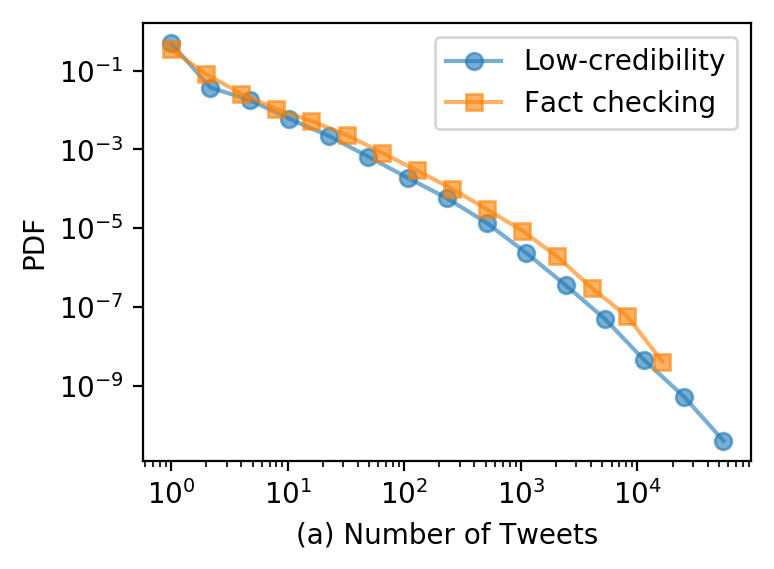

In [7]:
fn1 = join(DATA_DIR, 'M1a_ntweets_per_article.lc.csv')
fn2 = join(DATA_DIR, 'M1a_ntweets_per_article.ff.csv')
density = True
nbins = 15
base = 2
figsize = (4, 3)

df1 = pd.read_csv(fn1)
df2 = pd.read_csv(fn2)

# Note, set max bin points slightly larger than max data value
# because the calculation may make right most bin points
# a little smaller than max data value
bins1 = np.logspace(
    nplog(df1.counts.min(), base),
    nplog(df1.counts.max() + 1, base),
    nbins + 1,
    base=base)
bins2 = np.logspace(
    nplog(df2.counts.min(), base),
    nplog(df2.counts.max() + 1, base),
    nbins + 1,
    base=base)
if density is not True:
    w1 = np.ones_like(df1.counts.values) / len(df1.counts.values)
    w2 = np.ones_like(df2.counts.values) / len(df2.counts.values)
else:
    w1 = None
    w2 = None

h1, bins1 = np.histogram(
    df1.counts.values, bins=bins1, weights=w1, density=density)
h2, bins2 = np.histogram(
    df2.counts.values, bins=bins2, weights=w2, density=density)
f, ax = plt.subplots(figsize=figsize)
ax.set_xlabel('(a) Number of Tweets')
ax.set_ylabel('PDF')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(
    bins1[:-1], h1, c=C1, marker='o', alpha=0.6, label='Low-credibility')
ax.plot(bins2[:-1], h2, c=C2, marker='s', alpha=0.6, label='Fact checking')
ax.legend()
plt.tight_layout()
plt.show()

### Figure 1b & 1c

Please check the Gephi files under `visualization`.

### Figure 2a

Helper function for ternary plot 2a

In [8]:
def prepare_ternary(figsize, scale):
    """Help function to ternary plot"""
    fig, ax = plt.subplots(figsize=figsize)
    tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    ax.axis('off')
    gm = 0.1 * scale
    blw = 1
    tlw = 1
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=blw)
    tax.gridlines(color='grey', multiple=gm, alpha=0.8)
    # Set Axis labels and Title
    tax.bottom_axis_label(
        r"Retweets $\rightarrow$", offset=0.2, fontsize='small')
    tax.right_axis_label(r"$\leftarrow$Replies", offset=0.2, fontsize='small')
    tax.left_axis_label(r"$\leftarrow$Tweets", offset=0.2, fontsize='small')

    # ticks
    locations = range(0, scale + 1, 4)
    ticks = [x * 10 for x in range(0, 11, 2)]
    tax.ticks(
        axis='lbr',
        ticks=ticks,
        locations=locations,
        linewidth=tlw,
        offset=0.03,
        clockwise=False)
    return tax

**Caption in the main paper**:

Figure 2: Anomalies. The distribution of types of tweet spreading articles from (a) low-credibility ...

**Input data and instructions**:

`M2a_types_of_tweets.lc.csv`: providing the statistics of the types of tweets for each article. You should have the knowledge of how to recognize the different types of tweets.

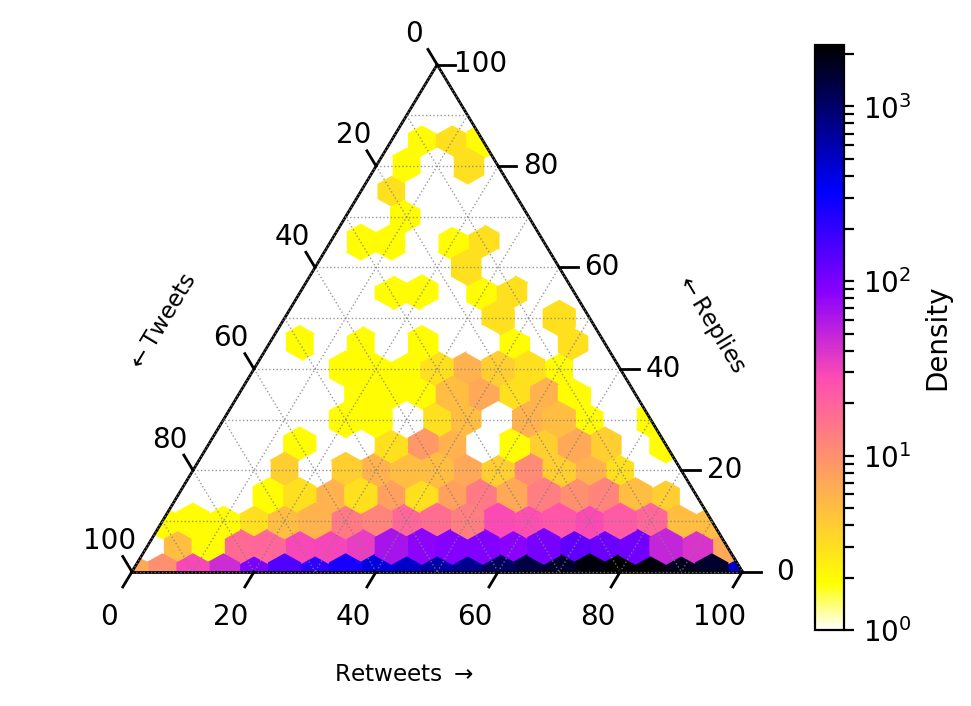

In [10]:
fn = join(DATA_DIR, 'M2a_types_of_tweets.lc.csv')
ntop = None
least_ntweets=100
scale=20
style='hexagonal'
figsize=(5, 3.5)

df = pd.read_csv(fn)
df.set_index('id', inplace=True)
df['ntotal'] = df.sum(axis=1)
df = df.sort_values('ntotal', ascending=False)
logger.info('Total artilces %s', len(df))

if ntop is not None:
    df = df.iloc[:ntop]
if least_ntweets is not None:
    df = df.loc[df.ntotal >= least_ntweets]
logger.info('Number of articles to visualize, %s', len(df))

X = ((df.nretweets + df.nquotes) / df.ntotal * scale).values
Y = (df.nreplies / df.ntotal * scale).values
Z = (df.norigins / df.ntotal * scale).values

data = heatmap_density(X, Y, Z, scale)
data = pd.Series(data)
vmin = data.min()
vmax = data.max()
data = data.apply(lambda x: np.log10(x + 1))
if vmin <= 0:
    vmin = 1
logger.info('vmin=%s, vmax=%r', vmin, vmax)
data = data.to_dict()
cmap = plt.cm.get_cmap('gnuplot2_r')
tax = prepare_ternary(figsize, scale)
tax.heatmap(
    data,
    cmap=cmap,
    style=style,
    colorbar=False,
)
colorbar_hack(
    ax=tax.ax,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    log_norm=True,
    cbarlabel='Density')
plt.tight_layout()
plt.show()

### Figure 2b

**Caption in the main paper**:

Figure 2: Anomalies. The distribution of types of tweet spreading articles from (a) low-credibility ...

**Input data and instructions**:

`m2b_types_of_tweets.ff.csv`: providing the statistics of the types of tweets for each article. You should have the knowledge of how to recognize the different types of tweets.

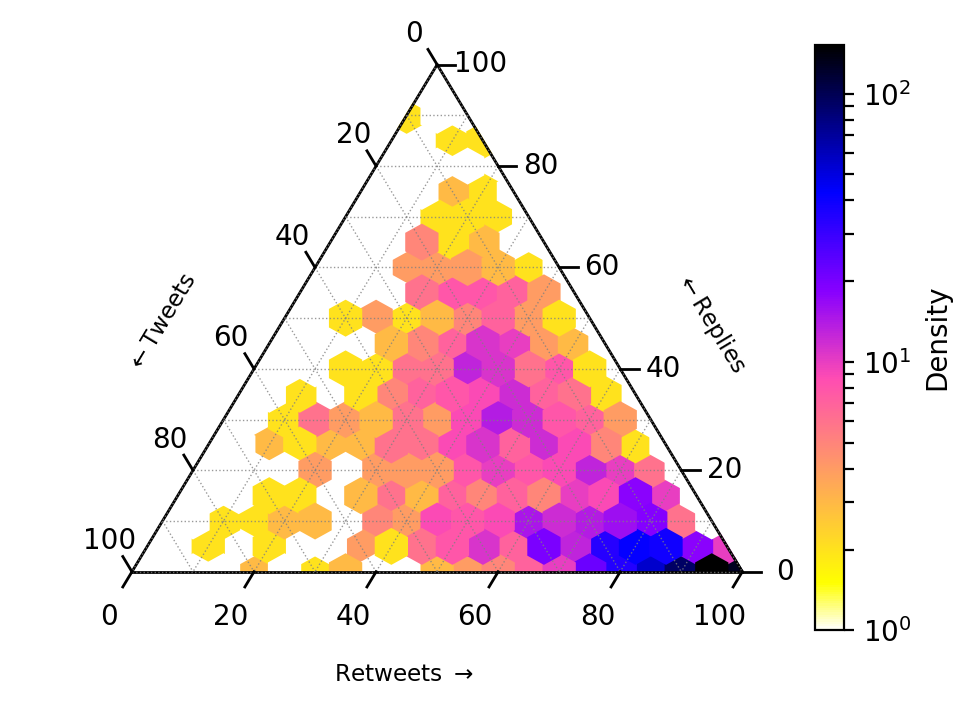

In [11]:
fn = join(DATA_DIR, 'm2b_types_of_tweets.ff.csv')
ntop = None
least_ntweets = 100
scale = 20
style = 'hexagonal'
figsize = (5, 3.5)


df = pd.read_csv(fn)
df.set_index('id', inplace=True)
df['ntotal'] = df.sum(axis=1)
df = df.sort_values('ntotal', ascending=False)
logger.info('Total artilces %s', len(df))

if ntop is not None:
    df = df.iloc[:ntop]
if least_ntweets is not None:
    df = df.loc[df.ntotal >= least_ntweets]
logger.info('Number of articles to visualize, %s', len(df))

X = ((df.nretweets + df.nquotes) / df.ntotal * scale).values
Y = (df.nreplies / df.ntotal * scale).values
Z = (df.norigins / df.ntotal * scale).values

data = heatmap_density(X, Y, Z, scale)
data = pd.Series(data)
vmin = data.min()
vmax = data.max()
data = data.apply(lambda x: np.log10(x + 1))
if vmin <= 0:
    vmin = 1
logger.info('vmin=%s, vmax=%r', vmin, vmax)
data = data.to_dict()
cmap = plt.cm.get_cmap('gnuplot2_r')
tax = prepare_ternary(figsize, scale)
tax.heatmap(
    data,
    cmap=cmap,
    style=style,
    colorbar=False,
)
colorbar_hack(
    ax=tax.ax,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    log_norm=True,
    cbarlabel='Density')
plt.tight_layout()
plt.show()

### Figure 2c

**Caption in the main paper**:

Figure 2: Anomalies. The distribution of types of tweet spreading articles from (a) low-credibility ...

**Input data and instructions**:

`M2c_article_gini_coef.csv`: the Gini coefficient (in terms of how the users share the same article) for each low-credibility article.

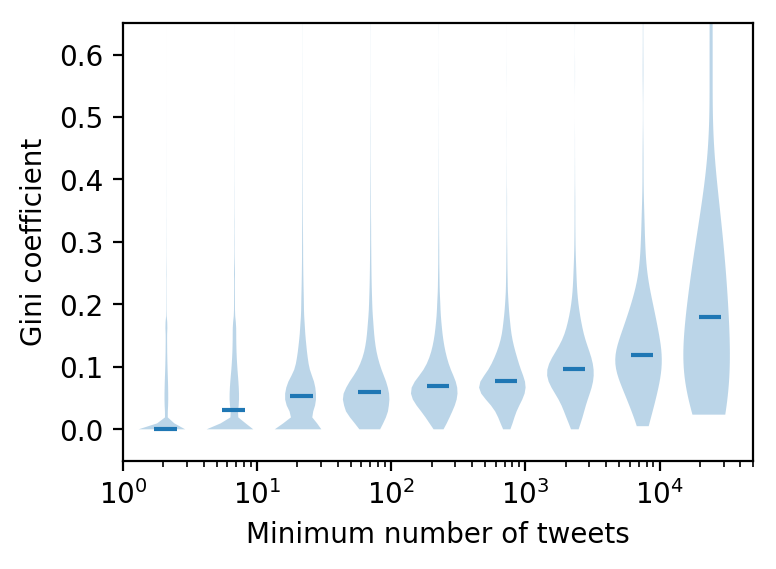

In [12]:
fn = join(DATA_DIR, 'M2c_article_gini_coef.csv')
nbins = 10
base = 10

df = pd.read_csv(fn)
bins = np.logspace(
    nplog(df.ntweets.min(), base),
    nplog(df.ntweets.max() + 1, base),
    nbins + 1,
    base=base)

data = []
for i in range(nbins):
    data.append(df.loc[(df.ntweets > bins[i])].gini.values)
    
positions = bins[:-1] + np.true_divide(bins[1:] - bins[:-1], 2)
f, ax = plt.subplots(figsize=FIGSIZE)
ax.set_ylabel('Gini coefficient')
ax.set_xlabel('Minimum number of tweets')
ax.violinplot(
    data,
    positions=positions,
    vert=True,
    widths=1.6 * bins[:-1],
    showmeans=False,
    showextrema=False,
    showmedians=True,
    points=100,
    bw_method='scott',
)

ax.set_xscale('log')
ax.set_xlim([1, 50000])
ax.set_ylim([-0.05, 0.65])
plt.tight_layout()
plt.show()

### Figure 2d

**Caption in the main paper**:

Figure 2: Anomalies. The distribution of types of tweet spreading articles from (a) low-credibility ...

**Input data and instructions**:

`M2d_top1000_users.lc.csv`: the top active (in terms of number of tweets) 1000 accounts with bot score that post tweets with a link to low-credibility sources

`M2d_rand1000_users.lc.csv`: the random sampled 1000 accounts with bot score that post tweets with a link to low-credibility sources.

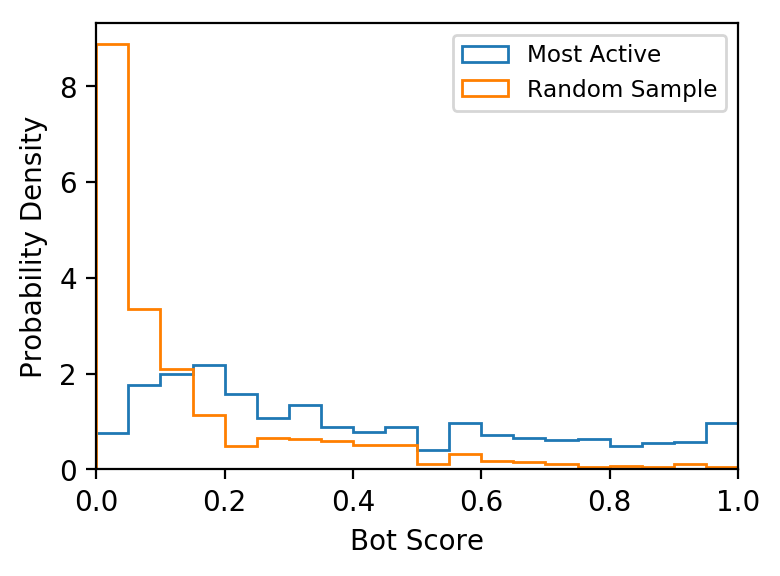

In [40]:
fn1 = join(DATA_DIR, 'M2d_top1000_users.lc.csv')
fn2 = join(DATA_DIR, 'M2d_rand1000_users.lc.csv')
nbins = 20
normed = True

df1 = pd.read_csv(fn1)
df2 = pd.read_csv(fn2)
a1 = df1.loc[df1.bot_score.notnull()].bot_score.values
a2 = df2.loc[df2.bot_score.notnull()].bot_score.values
mu1 = np.mean(a1)
sigma1 = np.std(a1, ddof=1)
mu2 = np.mean(a2)
sigma2 = np.std(a2, ddof=1)
logger.info('Number of Non-nan values: len(top)=%s, len(rand)=%s', len(a1), len(a2))
logger.info('Ratio of >0.5: r(top)=%s, r(rand)=%s',
            (a1 > 0.5).sum() / float(len(a1)),
            (a2 > 0.5).sum() / float(len(a2)))
logger.info('mu1=%s, mu2=%s', mu1, mu2)
logger.info('sigma1=%s, sigma2=%s', sigma1, sigma2)
logger.info('Welch\'s t-test: %s', ttest_ind(a1, a2, equal_var=False))
logger.info('Kolmogorov-Smirnov test: %s', ks_2samp(a1, a2))
logger.info('Mann Whitney U test: %s', mannwhitneyu(a1, a2))
fig, ax = plt.subplots(figsize=FIGSIZE)
bins = np.linspace(0, 1, nbins + 1)
if normed is False:
    w1 = np.ones_like(a1) / len(a1)
    w2 = np.ones_like(a2) / len(a2)
else:
    w1 = None
    w2 = None
ax.set_xlim([0, 1])
ax.hist(
    a1,
    bins,
    weights=w1,
    normed=normed,
    alpha=1,
    label='Most Active',
    histtype='step',
    color=C1)
ax.hist(
    a2,
    bins,
    weights=w2,
    normed=normed,
    alpha=1,
    label='Random Sample',
    histtype='step',
    color=C2)
plt.legend(loc='upper right', fontsize='small')
ax.set_xlabel('Bot Score')
if normed is True:
    ax.set_ylabel('Probability Density')
else:
    ax.set_ylabel('$proportion$')
plt.tight_layout()
plt.show()

### Figure 3a

**Caption in the main paper**:

Figure 3: Bot strategies. (a) Early bot support after a viral low-credibility article is first shared. We consider a sample of 60,000 accounts that participate in the spread of the 1,000 most viral stories from low-credibility sources. We align the times when each article
first appears. We focus on a one-hour early spreading phase following each of these events, and divide it into logarithmic lag intervals. The plot shows the bot score distribution for accounts sharing the articles during each of these lag intervals.

**Input data and instructions**:

`M3a_first_day_tweets_for_top1000_articles.lc.csv`: the first day tweets for the top 1000 low-credibility articles.

`M3a_sampled_users_with_score.csv`: the sampled accounts from `fn1` of size=60,000 and the bot score is attached.

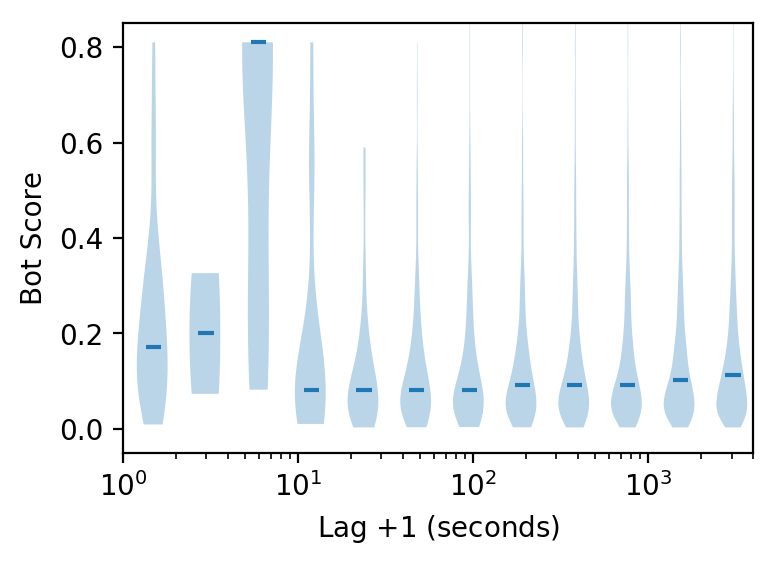

In [15]:
fn1 = join(DATA_DIR, 'M3a_first_day_tweets_for_top1000_articles.lc.csv')
fn2 = join(DATA_DIR, 'M3a_sampled_users_with_score.csv')
include_theonion = False
keep_first_accounts_only = False
base = 2

df1 = pd.read_csv(fn1)
df2 = pd.read_csv(fn2)
df1 = df1.loc[df1.seconds <= 3600]

if include_theonion is False:
    # site_id=129 for theonion.com
    df1 = df1.loc[df1.site_id != 129]
df = pd.merge(df1, df2, on='user_raw_id', how='inner')
df.sort_values('seconds', inplace=True, ascending=True)
if keep_first_accounts_only is True:
    logger.info('Keep first appeared tweets only!')
    logger.info('Before drop duplicates: %s', len(df))
    df = df.drop_duplicates(['article_id', 'user_raw_id'], keep='first')
    logger.info('After drop duplicates: %s', len(df))
X = df.seconds.values + 1
logger.info('Maximum seconds is: %s', X.max())
if len(df.loc[df.seconds == 1]) > 0:
    logger.info('bin [1,2) needed!')
    nxbins = int(np.ceil(nplog(X.max(), base=base))) + 1
    xbins = np.ones(nxbins + 1)
    xbins[1:] = 1 + base**np.arange(0, nxbins)
else:
    logger.info('bin [1,2) not needed!')
    nxbins = int(np.ceil(nplog(X.max(), base=base)))
    xbins = base**np.arange(0, nxbins + 1)
logger.info('xbins are %s', xbins)
data = []
# import pdb; pdb.set_trace()
for i in range(nxbins - 1):
    dfi = df.loc[(X >= xbins[i]) & (X < xbins[i + 1])]
    data.append(dfi.bot_score.values)
dfi = df.loc[(X >= xbins[nxbins - 1]) & (X <= xbins[nxbins])]
data.append(dfi.bot_score.values)
f, ax = plt.subplots(figsize=FIGSIZE)
positions = xbins[:-1] + np.true_divide(xbins[1:] - xbins[:-1], 2)
logger.info('positions=%s', positions)
ax.violinplot(
    data,
    positions=positions,
    vert=True,
    widths=0.6 * xbins[:-1],
    showmeans=False,
    showextrema=False,
    showmedians=True,
    points=100,
)
ax.set_xlabel('Lag $+1$ (seconds)')
ax.set_ylabel('Bot Score')
ax.set_ylim([-0.05, 0.85])
ax.set_xscale('log')
ax.set_xlim([1, 4e3])
plt.tight_layout()
plt.show()

### Figure 3b

Helper function for 3b

In [36]:
def assign_segregated_groups(df, ngroups=3):
    g_size, _ = divmod(len(df), ngroups)
    df['gn'] = -1
    windows = []
    left = 0
    df = df.reset_index(drop=True)
    for i in range(ngroups):
        cur_p = (i + 1) * g_size
        right = df.iloc[cur_p - 1].from_bot_score
        windows.append((left, right))
        left = right
    left, right = windows[-1]
    windows[-1] = (left, 1)
    for i, window in enumerate(windows):
        left, right = window
        df.loc[((df.from_bot_score > left) & (df.from_bot_score < right)
                ), 'gn'] = i
    df = df.loc[df.gn != -1]
    return df

**Caption in the main paper**:

Figure 3: Bot strategies. (a) Early bot support after a viral low-credibility article is first shared. We consider a sample of 60,000 accounts that participate in the spread of the 1,000 most viral stories from low-credibility sources. We align the times when each article first appears. We focus on a one-hour early spreading phase following each of these events, and divide it into logarithmic lag intervals. The plot shows the bot score distribution for accounts sharing the articles during each of these lag intervals.

**Input data and instructions**:

`M3b_sampled_mentions.60000.csv`: sampled mention tweets that both the mentioning accounts and mentioned accounts.

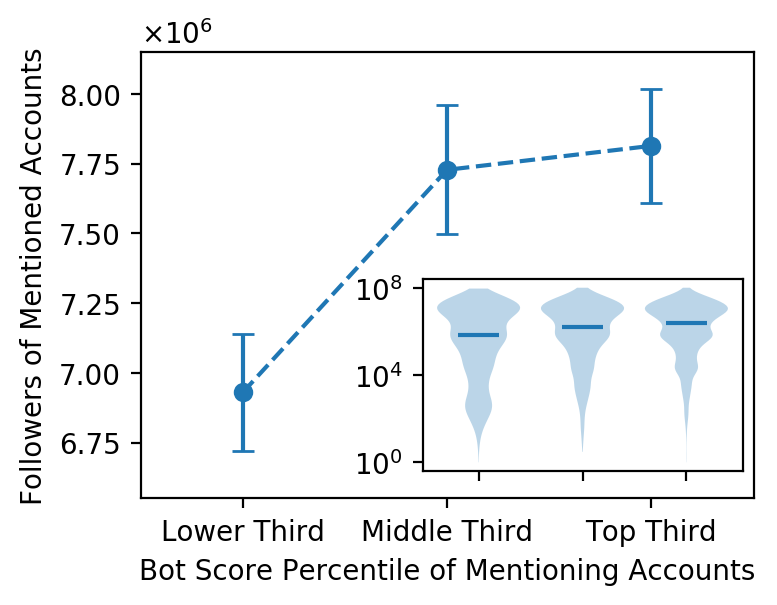

In [43]:
fn = join(DATA_DIR, 'M3b_sampled_mentions.60000.csv')
nbins = 3

df = pd.read_csv(fn)
df = df.loc[~df.is_via_word_in_tweet_text]
df = df[['from_raw_id', 'from_bot_score', 'to_followers_count']].copy()
df = df.groupby('from_raw_id').mean()
df = df.sort_values('from_bot_score', ascending=True)
df = df.reset_index(drop=True)
df = assign_segregated_groups(df, nbins)
gpb = df.groupby('gn')
d_mean = gpb.to_followers_count.mean()
d_std = gpb.to_followers_count.std()
d_size = gpb.size()
x = np.array(range(3))
y1 = d_mean.values / 1e6
y1err = d_std / d_size.apply(np.sqrt) / 1e6
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.errorbar(x, y1, yerr=y1err, fmt='--o', capsize=4)
ax.set_xticks(x)
ax.set_xticklabels(['Lower Third', 'Middle Third', 'Top Third'])
ax.set_xlabel('Bot Score Percentile of Mentioning Accounts')
ax.set_ylabel('Followers of Mentioned Accounts')
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([6.55, 8.15])
ax.text(
    0,
    1.02,
    r'$\times10^6$',
    transform=ax.transAxes,
    horizontalalignment='left')
iax = plt.axes([.54, .24, .4, .32])
df.loc[:, 'to_followers_count'] = np.log10(df.to_followers_count)
data = []
for name, gp in df.groupby('gn'):
    data.append(gp['to_followers_count'].values)
iax.violinplot(
    data,
    positions=x + 0.15,
    vert=True,
    widths=0.8,
    showmeans=False,
    showextrema=False,
    showmedians=True,
    points=100,
)
iax.set_xticks(x + 0.15)
iax.set_xticklabels([])
iax.set_yticks([0, 4, 8])
iax.yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, y: r'$10^%d$' % x))
plt.tight_layout()
plt.show()

### Figure 4

**Caption in the main paper**:

Figure 4: Impact of bots on humans. (a) Joint distribution of bot scores of accounts that retweeted links to low-credibility articles and accounts that had originally posted the links. Color represents the number of retweeted messages in each bin, on a log scale. (b) The top projection shows the distributions of bot scores for retweeters, who are mostly human. (c) The left projection shows the distributions of bot scores for accounts retweeted by likely humans (score below 0.5), with a significant portion of likely bots.

**Input data and instructions**:

`M4_retweeter_and_tweeter.csv`: retweeter and tweeter with bot score.

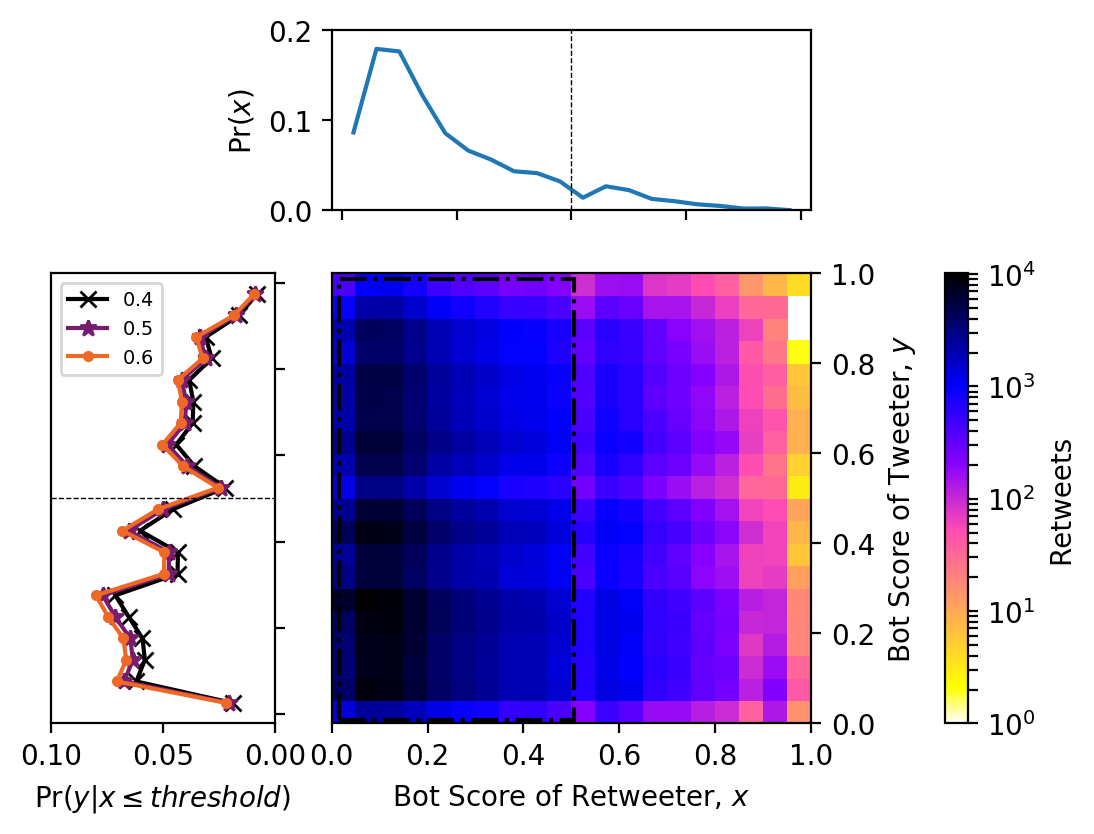

In [18]:
fn = join(DATA_DIR, 'M4_retweeter_and_tweeter.csv')
nbins = 20
figsize=(6, 4.5)

df = pd.read_csv(fn)
x = df.retweeter_score.values
y = df.tweeter_score.values
H, xedges, yedges = np.histogram2d(x, y, bins=np.linspace(0.0, 1.0, nbins + 1))
# X1, Y1, horizontal curve
df = pd.DataFrame(H)
X1 = xedges[:-1] + np.true_divide(xedges[1:] - xedges[:-1], 2)
Y1 = df.sum(axis=1) / df.sum(axis=1).sum()
# X2, Y2, vertical curve
df2 = df.iloc[:int(0.4 * nbins)]
X21 = df2.sum(axis=0) / df.sum(axis=0).sum()
df2 = df.iloc[:int(0.5 * nbins)]
X22 = df2.sum(axis=0) / df.sum(axis=0).sum()
df2 = df.iloc[:int(0.6 * nbins)]
X23 = df2.sum(axis=0) / df.sum(axis=0).sum()
Y2 = X1
# X3, Y3, heatmap
X3, Y3 = np.meshgrid(xedges, yedges)

plt.figure(figsize=figsize)
# Display -> Figure
# figtr = fig.transFigure.inverted()
gs = gridspec.GridSpec(
    2,
    4,
    wspace=0.3,
    hspace=0.2,
    width_ratios=[2.8, 6, 0.2, 0.5],
    height_ratios=[0.8, 2])
# gs[0, 1].update(hspace=0.1)
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[1, 3])
# horizontal curve
ax1.plot(X1, Y1)
# verticla curve
ax2.plot(X21, Y2, color='k', marker='x', label='$0.4$')
ax2.plot(X22, Y2, color='#781C6D', marker='*', label='$0.5$')
ax2.plot(X23, Y2, color='#ED6925', marker='.', label='$0.6$')
ax2.legend(fontsize='x-small')
# heatmap
im = ax3.pcolormesh(
    X3,
    Y3,
    H.T,
    norm=mpl.colors.LogNorm(vmin=H.min() + 1, vmax=H.max()),
    cmap='gnuplot2_r')
# color bar
cb = plt.colorbar(im, ax=ax4, orientation='vertical', fraction=0.9)
cb.set_label('Retweets')
# disable xticklabels of ax1
ax1.set_xticklabels([])
# disable xticklabels of ax2
ax2.set_yticklabels([])
# set tick on right yaxis of ax2
ax2.yaxis.tick_right()
# add vertical dashed line on ax1
ax1.axvline(0.5, color='k', linestyle='--', lw=0.5)
# add xlabel
ax1.set_ylabel('$\Pr(x)$')
ax1.set_ylim((0, 0.2))
# add horizontal dashed line on ax2
ax2.axhline(0.5, color='k', linestyle='--', lw=0.5)
# set inverse xlim of ax2, making xaxis increasing on inverse direction
ax2.set_xlim((0.1, 0))
# add ylabel
ax2.set_xlabel('$\Pr(y|x\leq threshold)$')
# fontsize=rcParams['axes.titlesize'],
# fontweight=rcParams['axes.titleweight'])
# set xlabel of ax3
ax3.set_xlabel('Bot Score of Retweeter, $x$')
# set ylabel of ax3
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Bot Score of Tweeter, $y$')
# disable axis
ax4.axis('off')
# add rectangel for ax3
rect = mpl.patches.Rectangle(
    (0.015, 0.008),
    0.49,
    0.98,
    alpha=1,
    ec='black',
    facecolor=None,
    fill=False,
    ls='-.',
    lw=1.5)
ax3.add_patch(rect)
plt.show()

### Figure 5

Helper functions for Figure 5

In [19]:
def remaining_claim_url(tweet_df, user_centrality_series):
    tweet_df = tweet_df.copy()
    ordered_uid = [
        str(uid)
        for uid in user_centrality_series.sort_values(ascending=False).index
    ]
    user_rank_dict = {uid: rank + 1 for rank, uid in enumerate(ordered_uid)}
    retweet_removal_order = \
        np.minimum(
            tweet_df.from_raw_id.apply(lambda uid: user_rank_dict[uid]),
            tweet_df.to_raw_id.apply(lambda uid: user_rank_dict[uid])
        )
    tweet_df['retweet_removal_order'] = retweet_removal_order
    link_removal_order = tweet_df.groupby('article_id')[
        'retweet_removal_order'].max()
    counts = {user_rank_dict[uid]: 0.0 for uid in ordered_uid}
    counts.update(link_removal_order.value_counts().to_dict())
    removed = pd.Series(counts).sort_index()
    remaining = 1.0 - removed.cumsum() / removed.sum()
    remaining = pd.concat([pd.Series([1.0], index=[0.0]), remaining])
    remaining.index += 1
    return remaining


def remaining_percentage(tweet_df, user_centrality_series):
    ordered_uid = [
        str(uid)
        for uid in user_centrality_series.sort_values(ascending=False).index
    ]
    user_rank_dict = {uid: rank + 1 for rank, uid in enumerate(ordered_uid)}
    removal_order = \
        np.minimum(
            tweet_df.from_raw_id.apply(lambda uid: user_rank_dict[uid]),
            tweet_df.to_raw_id.apply(lambda uid: user_rank_dict[uid])
        )
    counts = {user_rank_dict[uid]: 0.0 for uid in ordered_uid}
    counts.update(removal_order.value_counts().to_dict())
    removed = pd.Series(counts).sort_index()
    remaining = 1.0 - removed.cumsum() / removed.sum()
    remaining = pd.concat([pd.Series([1.0], index=[0.0]), remaining])
    remaining.index += 1
    return remaining

**Caption in the main paper**:

Figure 5: Dismantling the low-credibility content diffusion network. The priority of disconnected nodes is determined by ranking accounts on the basis of different characteristics. The remaining fraction of (a) unique articles from low-credibility sources and (b) retweets linking to those articles is plotted versus the number of disconnected nodes.

**Input data and instructions**:

`M5_retweet.20171108.lc.csv`: retweets with links to low-credibility sources before 2017-11-08.

`M5_centralities.csv`: three centralities for users with large k-core number: in-strength,
out-strength, and bot-score.

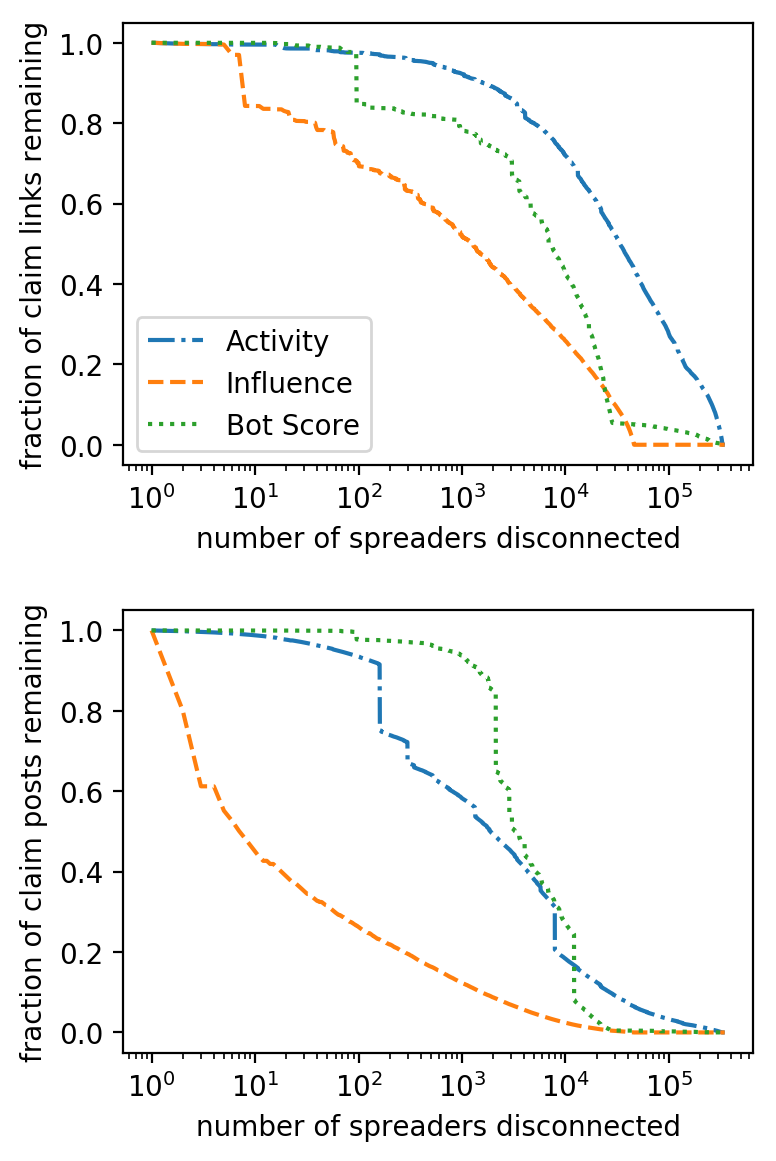

In [20]:
fn1 = join(DATA_DIR, 'M5_retweet.20171108.lc.csv')
fn2 = join(DATA_DIR, 'M5_centralities.csv')

df1 = pd.read_csv(fn1, dtype=dict(from_raw_id=str, to_raw_id=str))
df2 = pd.read_csv(fn2, index_col=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))
plot_kw = dict(ax=ax1, logx=True)
remaining_claim_url(df1, df2['in_s']).plot(
    label='Activity', linestyle='-.', **plot_kw)
remaining_claim_url(df1, df2['out_s']).plot(
    label='Influence', linestyle='--', **plot_kw)
remaining_claim_url(df1, df2['bot_score']).plot(
    label='Bot Score', linestyle=':', **plot_kw)
ax1.set_xlabel('number of spreaders disconnected')
ax1.set_ylabel('fraction of claim links remaining')
ax1.legend()

plot_kw = dict(ax=ax2, logx=True)
remaining_percentage(df1, df2['in_s']).plot(
    label='Activity', linestyle='-.', **plot_kw)
remaining_percentage(df1, df2['out_s']).plot(
    label='Influence', linestyle='--', **plot_kw)
remaining_percentage(df1, df2['bot_score']).plot(
    label='Bot Score', linestyle=':', **plot_kw)
ax2.set_xlabel('number of spreaders disconnected')
ax2.set_ylabel('fraction of claim links remaining')
# ax2.legend(loc=3, fontsize=9)
ax2.set_xlabel('number of spreaders disconnected')
ax2.set_ylabel('fraction of claim posts remaining')
plt.tight_layout()
plt.show()

### Figure 6

**Caption in the main paper**:

Figure 6: Popularity and bot support for the top sources. Satire websites are shown in orange, fact-checking sites in blue, and low-credibility sources in red. Popularity is measured by total tweet volume (horizontal axis) and median number of tweets per article (circle area). Bot support is gauged by the median bot score of the 100 most active accounts posting links to articles from each source (vertical axis). Low-credibility sources have greater support by bots, as well as greater median and/or total volume in many cases.

**Input data and instructions**:

`M6_top_sources_popularity.csv`: the statistics for the top 20 most active sources (in terms of number of tweets), including total number of tweets, median bot score of the 100 most active accounts, median number of tweets per article.

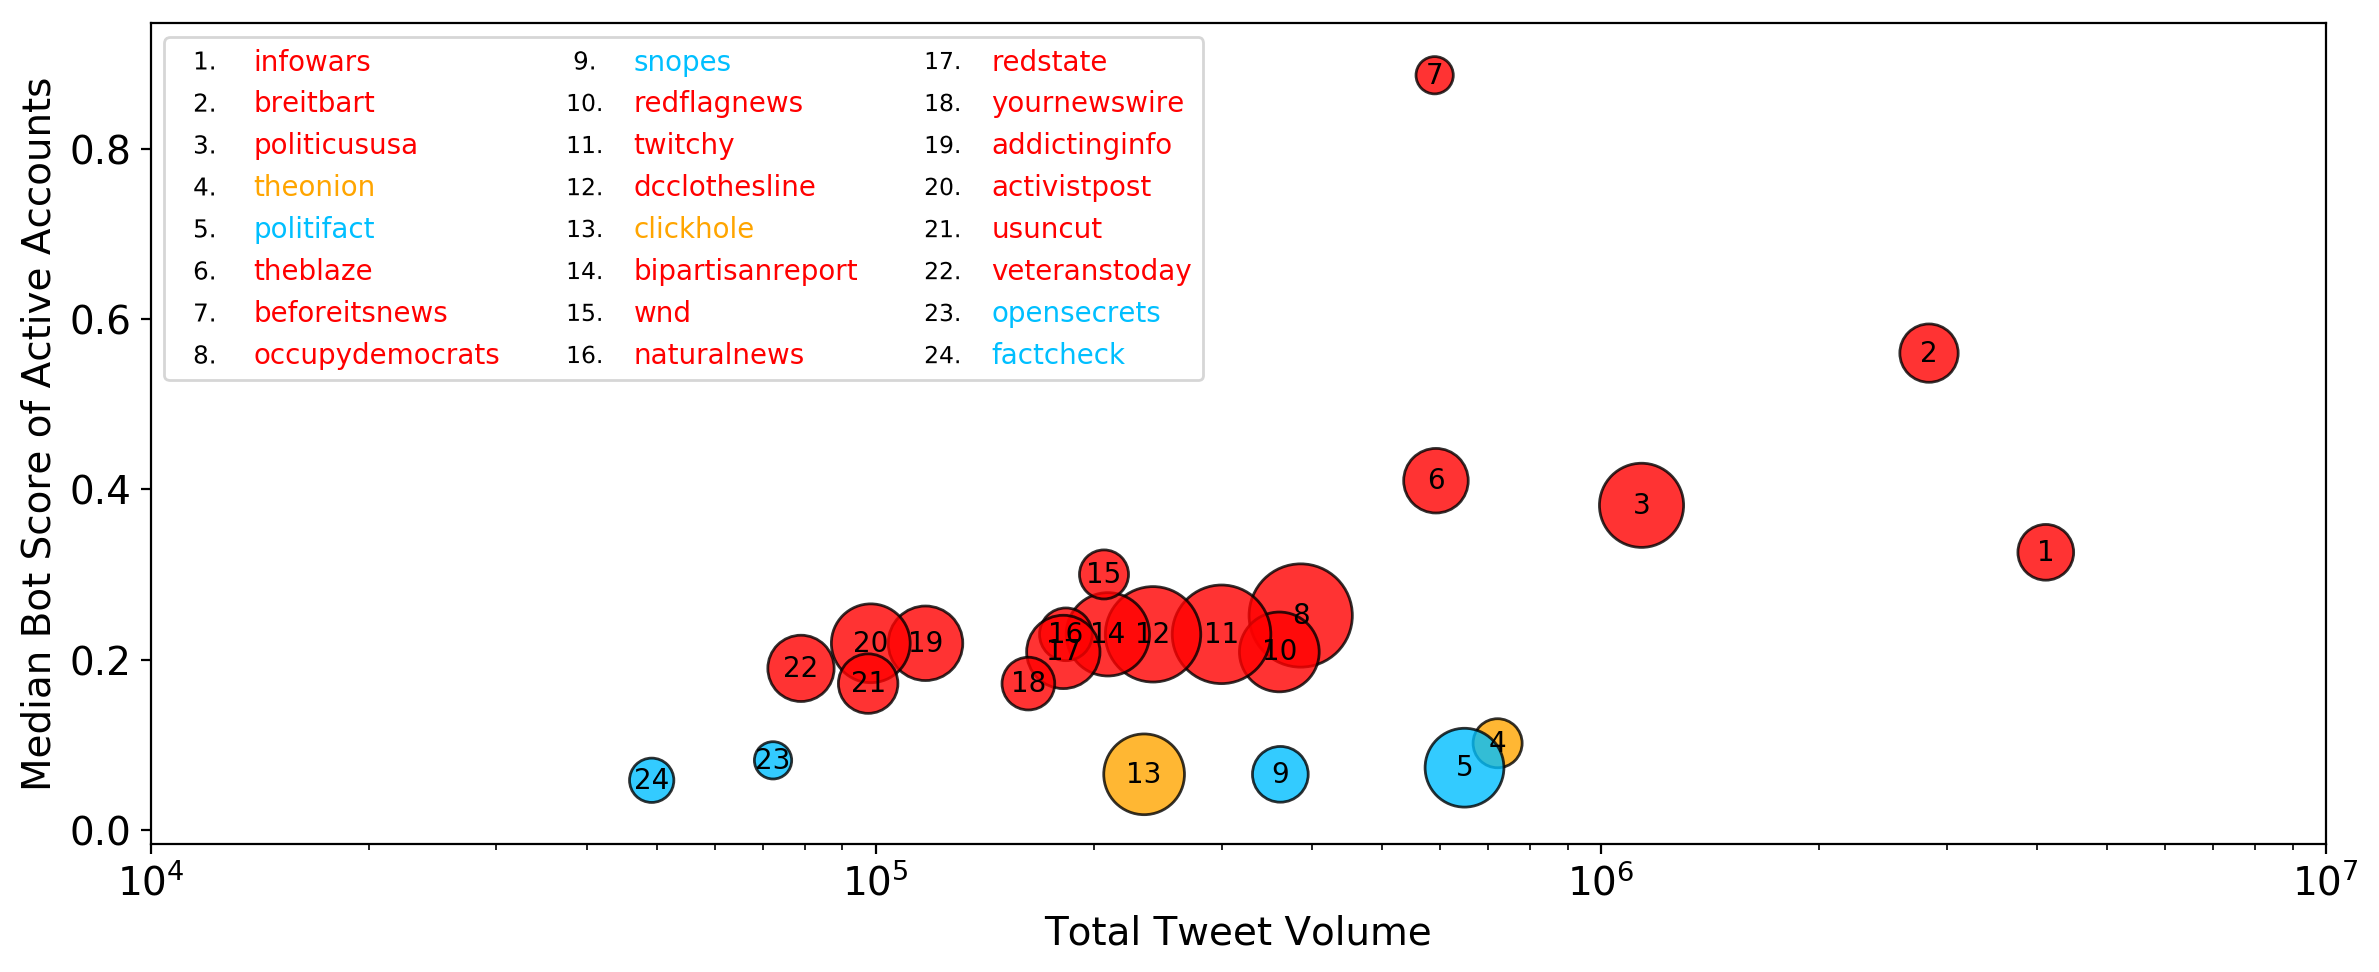

In [21]:
fn = join(DATA_DIR, 'M6_top_sources_popularity.csv')
figsize=(12, 5)

df = pd.read_csv(fn)
df.rename(
    columns=dict(
        median_of_tweets_per_article='at_medians',
        median_of_bot_score_of_top_users='bs_medians',
        total_tweets='ntweets'),
    inplace=True)
df = df.sort_values('ntweets', ascending=False)
# trim domains top label
df.domain = df.domain.apply(lambda x: x[:-4])
# size configuration
base_v = df.at_medians.min()
scale = np.sqrt(df.at_medians.values / base_v)
base_s = 180
sizes = scale * base_s
# color configuration
color_low_credibility = 'red'
color_satire = 'orange'
color_fact_checking = 'deepskyblue'
df['color'] = color_low_credibility
df.loc[df.site_type == 'fact_checking', 'color'] = color_fact_checking
df.loc[df.site_type == 'satire', 'color'] = color_satire
# start ploting
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(
    df.ntweets.values,
    df.bs_medians.values,
    s=sizes,
    color=df.color.values,
    edgecolors='k',
    alpha=0.8)
# Set lables for the scattered point
for txt, x, y, sc in zip(
        range(len(df)), df.ntweets.tolist(), df.bs_medians.tolist(),
        scale):
    ax.annotate(
        txt + 1,
        xy=(x, y),
        # xytext=(0, sc * base_yt),
        # textcoords='offset points',
        # fontsize=nplog(sc + 1, 2) * base_fs,
        ha='center',
        va='center')
# set legend
handlers = [
    mpl.lines.Line2D(
        [0], [0],
        linestyle='none',
        mfc='black',
        mec='none',
        marker=r'$\mathregular{{{}.}}$'.format(i),
        markersize=7.5) for i in range(1, 10)
]
handlers += [
    mpl.lines.Line2D(
        [0], [0],
        linestyle='none',
        mfc='black',
        mec='none',
        marker=r'$\mathregular{{{}.}}$'.format(i),
        markersize=12.5) for i in range(10,
                                        len(df) + 1)
]
plt.legend(handlers, df.domain.tolist(), ncol=3, loc=2)
# set colors of legend text
# pdb.set_trace()
for lh, c in zip(ax.get_legend().get_texts(), df.color.tolist()):
    lh.set_color(c)
ax.set_xlabel('Total Tweet Volume', fontsize=14)
ax.set_ylabel('Median Bot Score of Active Accounts', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xscale('log')
ax.set_xlim(1e4, 1e7)
plt.tight_layout()
plt.show()

## Supplementary Information

### Figure S1

**Caption in the supplementary paper**:

Extended Data Figure 1: Weekly tweeted low-credibility articles, tweets/article ratio and articles/site ratio. The collection was briefly interrupted in October 2016. In December 2016 we expanded the set of low-credibility sources, from 70 to 120 websites.

**Input data and instructions**:

`S1_new_articles.weekly.lc.csv`: weekly new coming articles from low-credibility sources

`S1_tweeted_articles.weekly.lc.csv`: weekly tweeted articles from low-credibility sources

`S1_new_tweets.weekly.lc.csv`: weekly new coming tweets with links to low-credibility sources


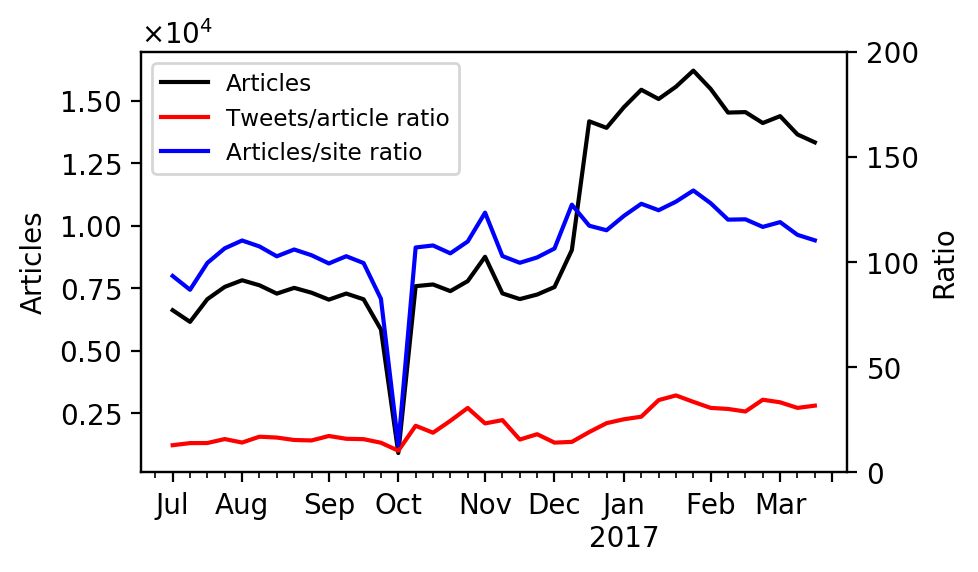

In [22]:
fn1 = join(DATA_DIR, 'S1_new_articles.weekly.lc.csv')
fn2 = join(DATA_DIR, 'S1_tweeted_articles.weekly.lc.csv')
fn3 = join(DATA_DIR, 'S1_new_tweets.weekly.lc.csv')

trim_edge = True
trim_broken = False
figsize=(5, 3)

df1 = pd.read_csv(fn1, parse_dates=['wtimeline'])
df2 = pd.read_csv(fn2, parse_dates=['wtimeline'])
df3 = pd.read_csv(fn3, parse_dates=['wtimeline'])
df1.columns = ['timeline', 'nclaim']
df2.columns = ['timeline', 'wclaim']
df3.columns = ['timeline', 'ntweet']
df = pd.merge(df1, df2, on='timeline', how='inner')
df = pd.merge(df, df3, on='timeline', how='inner')
df['site'] = 71
df.set_index('timeline', inplace=True)
dt = date(2016, 12, 20)
dt = dt - timedelta(days=dt.weekday())
df.loc[dt:, 'site'] = 121
df['tpa'] = df.ntweet / df.wclaim
df['aps'] = df.nclaim / df.site
df = df[['nclaim', 'tpa', 'aps']]
if trim_edge is True:
    df = df.iloc[1:-1]
if trim_broken is True:
    df.loc['2016-09-26', :] = np.nan
    df.loc['2016-10-03', :] = np.nan
colors = ['black', 'red', 'blue']
# pdb.set_trace()
ax = df.plot(
    secondary_y=['tpa', 'aps'],
    color=colors,
    figsize=figsize,
    legend=False)
ax.set_ylabel('Articles')
ax.set_xlabel('')
ax.right_ax.set_ylabel('Ratio')
ax.right_ax.set_ylim([0, 200])
ln1, _ = ax.get_legend_handles_labels()
ln2, _ = ax.right_ax.get_legend_handles_labels()
ax.legend(
    ln1 + ln2, ('Articles', 'Tweets/article ratio', 'Articles/site ratio'),
    fontsize='small')
mf = mpl.ticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((-1, 2))
ax.yaxis.set_major_formatter(mf)
plt.tight_layout()
plt.show()

### Figure S2

**Caption in the supplementary paper**:

Extended Data Figure 2: Probability distributions of popularity of articles from low-credibility and fact-checking sources, measured by (a) the number of tweets and (b) the number of accounts sharing links to an article.

**Input data and instructions**:

`M1a_ntweets_per_article.lc.csv`: number of tweets per article for low-credibility sources

`M1a_ntweets_per_article.ff.csv`: number of tweets per article for fact-checking sources

`S2_nusers_per_article.lc.csv`: number of users per article for fact-checking sources

`S2_nusers_per_article.ff.csv`: number of users per article for fact-checking sources

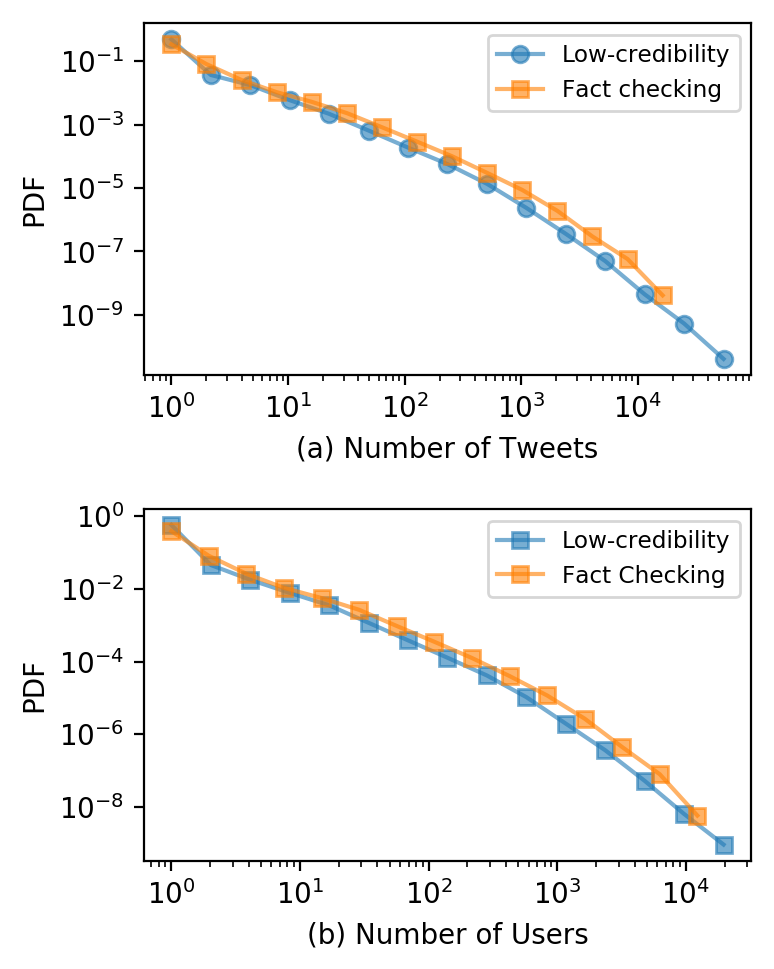

In [24]:
fn11 = join(DATA_DIR, 'M1a_ntweets_per_article.lc.csv')
fn12 = join(DATA_DIR, 'M1a_ntweets_per_article.ff.csv')
fn21 = join(DATA_DIR, 'S2_nusers_per_article.lc.csv')
fn22 = join(DATA_DIR, 'S2_nusers_per_article.ff.csv')

density=True
nbins=15
base=2
figsize=(4, 5)

df11 = pd.read_csv(fn11)
df12 = pd.read_csv(fn12)
df21 = pd.read_csv(fn21)
df22 = pd.read_csv(fn22)
# Note, set max bin points slightly larger than max data value
# because the calculation may make right most bin points
# a little smaller than max data value
bins11 = np.logspace(
    nplog(df11.counts.min(), base),
    nplog(df11.counts.max() + 1, base),
    nbins + 1,
    base=base)
bins12 = np.logspace(
    nplog(df12.counts.min(), base),
    nplog(df12.counts.max() + 1, base),
    nbins + 1,
    base=base)
bins21 = np.logspace(
    nplog(df21.counts.min(), base),
    nplog(df21.counts.max() + 1, base),
    nbins + 1,
    base=base)
bins22 = np.logspace(
    nplog(df22.counts.min(), base),
    nplog(df22.counts.max() + 1, base),
    nbins + 1,
    base=base)
if density is not True:
    w11 = np.ones_like(df11.counts.values) / len(df11.counts.values)
    w12 = np.ones_like(df12.counts.values) / len(df12.counts.values)
    w21 = np.ones_like(df21.counts.values) / len(df21.counts.values)
    w22 = np.ones_like(df22.counts.values) / len(df22.counts.values)
else:
    w11 = None
    w12 = None
    w21 = None
    w22 = None

h11, bins11 = np.histogram(
    df11.counts.values, bins=bins11, weights=w11, density=density)
h12, bins12 = np.histogram(
    df12.counts.values, bins=bins12, weights=w12, density=density)
h21, bins21 = np.histogram(
    df21.counts.values, bins=bins21, weights=w21, density=density)
h22, bins22 = np.histogram(
    df22.counts.values, bins=bins22, weights=w22, density=density)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
ax1.set_xlabel('(a) Number of Tweets')
ax1.set_ylabel('PDF')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel('(b) Number of Users')
ax2.set_ylabel('PDF')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax1.plot(
    bins11[:-1], h11, c=C1, marker='o', alpha=0.6, label='Low-credibility')
ax1.plot(
    bins12[:-1], h12, c=C2, marker='s', alpha=0.6, label='Fact checking')
ax2.plot(
    bins21[:-1], h21, c=C1, marker='s', alpha=0.6, label='Low-credibility')
ax1.legend(fontsize='small')
ax2.plot(
    bins22[:-1], h22, c=C2, marker='s', alpha=0.6, label='Fact Checking')
ax2.legend(fontsize='small')

plt.tight_layout()
plt.show()

### Figure S3

Not derived from data.

### Figure S4

Simple pie chart.

### Figure S5

Not derived from data.

### Figure S6

**Caption in the supplementary paper**:

Supplementary Figure 6: Cumulative distribution of repetitions, i.e., the number of times a single account tweets the same link to an article from a low-credibility source.

**Input data and instructions**:

`S6_ntweets_per_user_article.lc.csv`: number of tweets for each article (from low-credibility sources) that is shared by the same user.

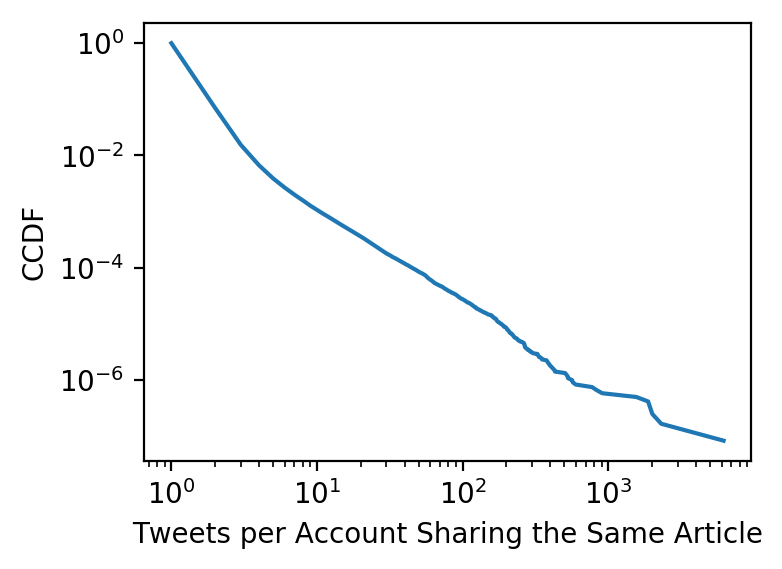

In [25]:
fn = join(DATA_DIR, 'S6_ntweets_per_user_article.lc.csv')

df = pd.read_csv(fn)
s = ccdf(df.ncounts)

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(s.index, s.values)
ax.set_xlabel('Tweets per Account Sharing the Same Article')
ax.set_ylabel('CCDF')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([0.8, 200])
plt.tight_layout()
plt.show()

### Figure S7

Please check the Gephi file under `visualization`.

### Figure S8

**Caption in the supplementary paper**:

Supplementary Figure 8: Fraction of tweets linking to news articles that are posted by accounts with bot score above a threshold, as a function of the popularity of the linked articles.  We see different bot activity for articles from low-credibility (left) versus fact-checking (right) sources.

**Input data and instructions**:

`S8_S9_binned_claims.json.txt`: sampled and binned tweets containing claims with bot scores for the accounts behind those tweets

`S8_S9_binned_factchecking.json.txt`: sampled and binned tweets containing factchecking with bot scores for the accounts behind those tweets

`S8_S9_binned_mainstream.json.txt`: sampled and binned tweets containing mainstream media articles with bot scores the accounts behind those tweets

To obtain the first two files, sample the `tweets.all.csv` file using logarithmic bins based on the number of tweets per article then consult `user_bot_score.calibrated.csv` for the bot score for the accounts.

To obtain the third file, sample the `main_stream_tweets.csv` file using logarithmic bins based on the number of tweets per article then consult `mainstream_user_bot_score.calibrated.csv` for the bot score for the accounts.

Configurations for S8 and S9

In [16]:
botThres = [0.4,0.5,0.6]
markers = ['x','*','o','p','s']
cmap = matplotlib.cm.get_cmap('inferno')

Load the data for S8 and S9

In [14]:
fn1 = join(DATA_DIR, "S8_S9_binned_claims.json.txt")
fn2 = join(DATA_DIR, "S8_S9_binned_factchecking.json.txt")
fn3 = join(DATA_DIR, "S8_S9_binned_mainstream.json.txt")
binnedDataClaim = json.load(open(fn1))
binnedDataFactChecking = json.load(open(fn2))
binnedDataMainStream= json.load(open(fn3))

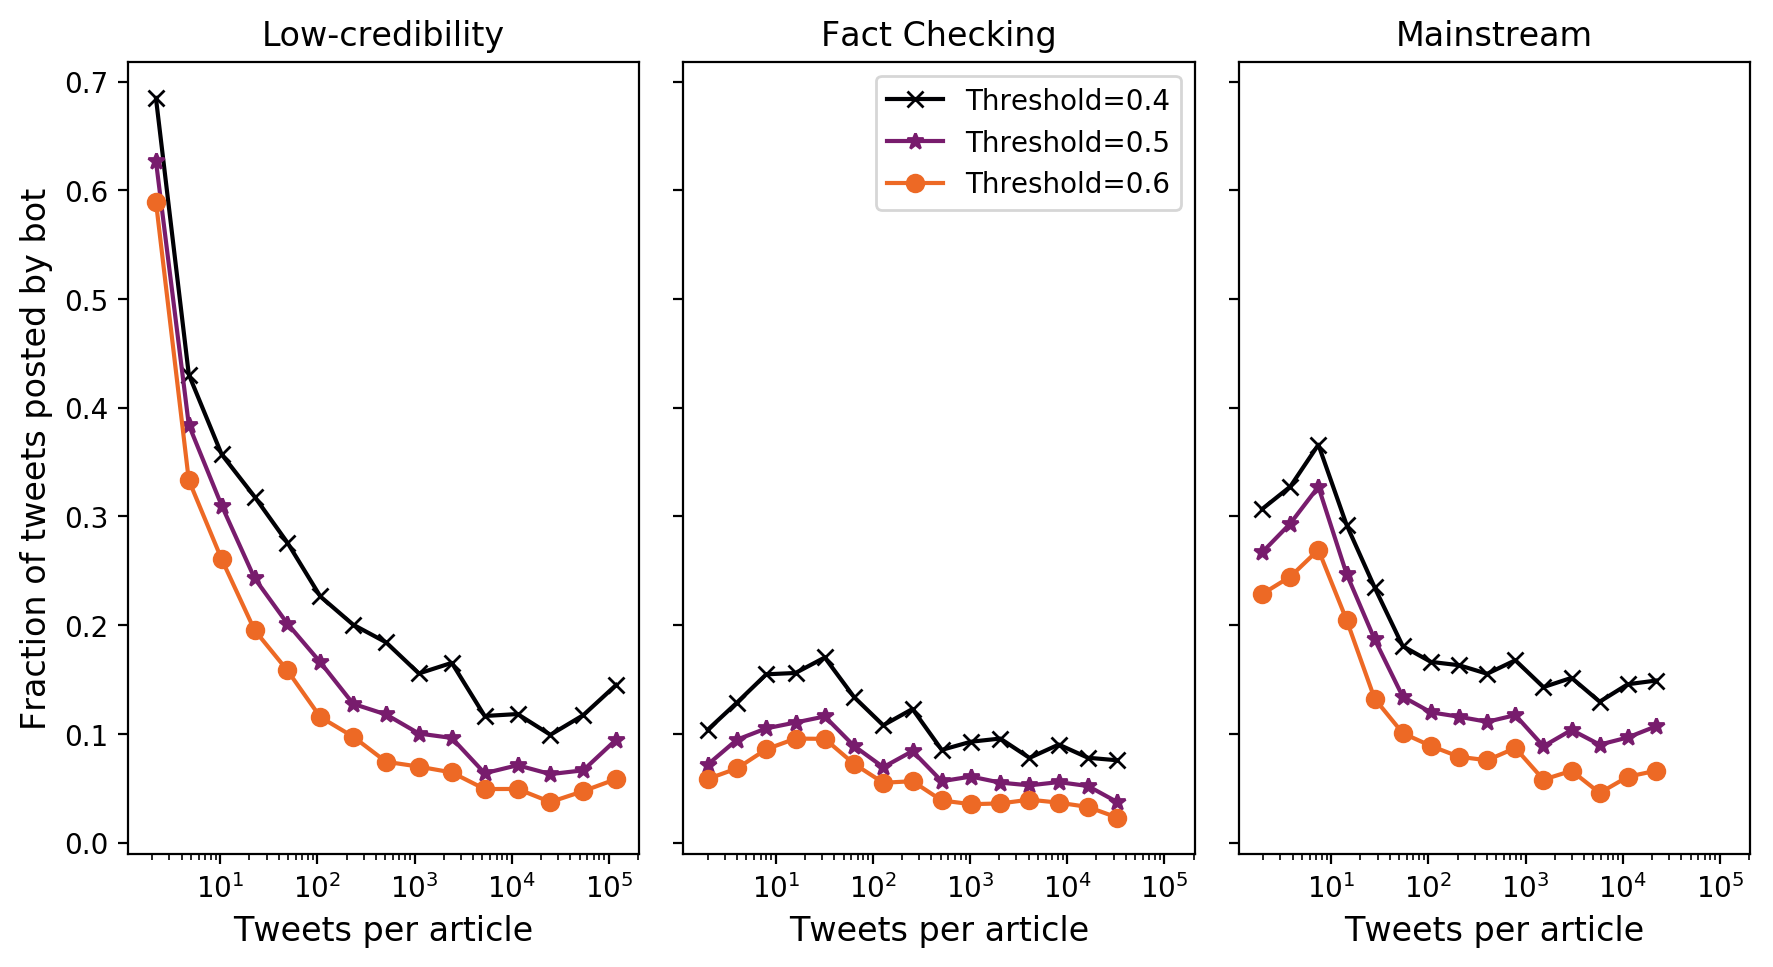

In [25]:
fig, axArr = plt.subplots(1,3, figsize=(9,5), sharex=True, sharey=True)

for i,t in enumerate(botThres):
    xvals, yvals = list(), list()
    for b in binnedDataClaim:
        nAvail = sum([1 for s in b['bot-scores']])
        xvals.append(b['bin'])
        yvals.append(sum([1 for s in b['bot-scores'] if s > t])/float(nAvail))
    axArr[0].plot(xvals, yvals, '{}-'.format(markers[i]), label='Threshold={}'.format(t), c=cmap(i/float(len(botThres))))
axArr[0].set_xscale('log')
axArr[0].set_title('Low-credibility', fontsize=12)
axArr[0].set_xlabel('Tweets per article', fontsize=12)
axArr[0].set_ylabel('Fraction of tweets posted by bot', fontsize=12)

for i,t in enumerate(botThres):
    xvals, yvals = list(), list()
    for b in binnedDataFactChecking:
        nAvail = sum([1 for s in b['bot-scores']])
        xvals.append(b['bin'])
        yvals.append(sum([1 for s in b['bot-scores'] if s > t])/float(nAvail))
    axArr[1].plot(xvals, yvals, '{}-'.format(markers[i]), label='Threshold={}'.format(t), c=cmap(i/float(len(botThres))))
axArr[1].set_xscale('log')
axArr[1].set_title('Fact Checking', fontsize=12)
axArr[1].set_xlabel('Tweets per article', fontsize=12)
plt.tight_layout()
axArr[1].legend(loc='upper right')

for i,t in enumerate(botThres):
    xvals, yvals = list(), list()
    for b in binnedDataMainStream:
        nAvail = sum([1 for s in b['bot-scores']])
        xvals.append(b['bin'])
        #yvals.append(sum([1 for s in b['bot-scores'] if s > 0.5])/len(b['bot-scores']))
        yvals.append(sum([1 for s in b['bot-scores'] if s > t])/float(nAvail))
    axArr[2].plot(xvals, yvals, '{}-'.format(markers[i]), label='Threshold={}'.format(t), c=cmap(i/float(len(botThres))))
axArr[2].set_xscale('log')
axArr[2].set_title('Mainstream', fontsize=12)
axArr[2].set_xlabel('Tweets per article', fontsize=12)
plt.tight_layout()

plt.show()

### Figure S9

**Caption in the supplementary paper**:

Supplementary Figure 9: For links to articles from low-credibility (left) and fact-checking (right)sources, the number of tweets by accounts with bot score above a threshold is plotted versus thenumber of tweets by accounts with bot score below the threshold.  The dashed lines are guides tothe eye, showing linear growth. A super-linear relationship is a signature of amplification by bots.

**Input data and instructions**:

`S8_S9_binned_claims.json`: sampled and binned tweets containing claims with bot scores for the accounts behind those tweets

`S8_S9_binned_factchecking.json`: sampled and binned tweets containing factchecking with bot scores for the accounts behind those tweets

To obtain the two files, sample the `tweets.all.csv` file using logarithmic bins based on the number of tweets per article then consult `user_bot_score.calibrated.csv` for the bot score for the accounts.

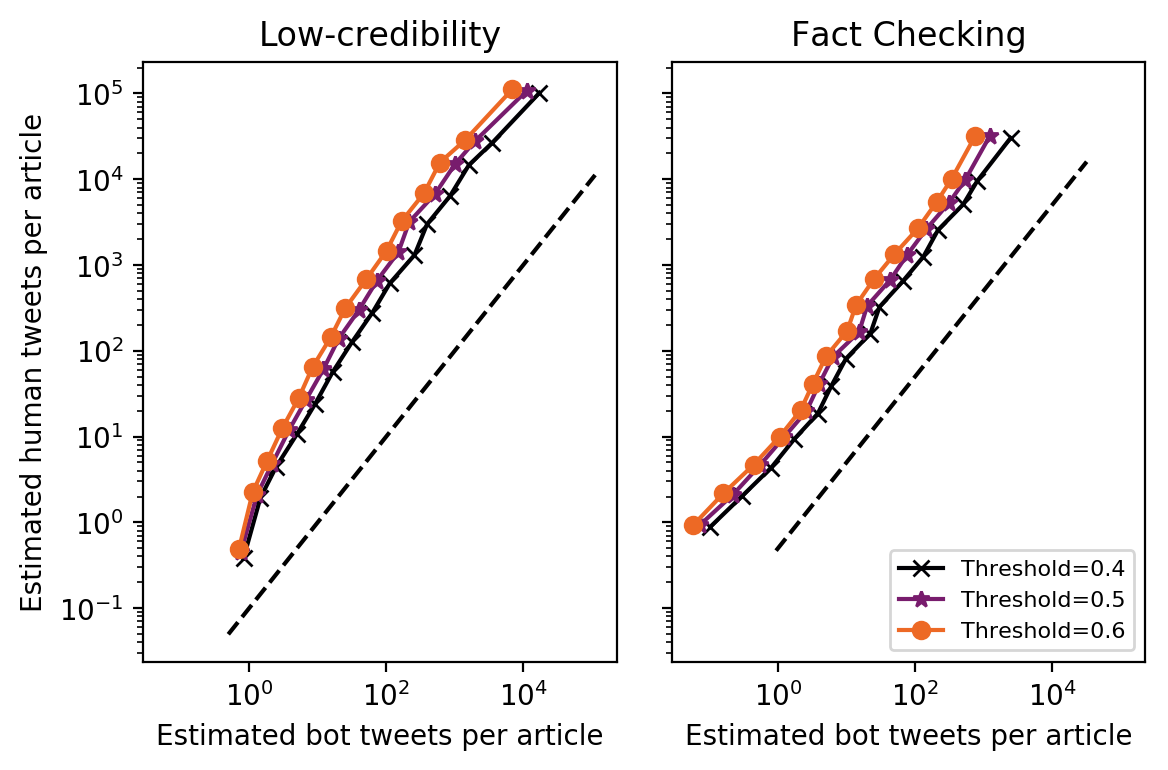

In [29]:
fig, axArr = plt.subplots(1,2, figsize=(6,4), sharex=True, sharey=True)

for i,t in enumerate(botThres):
    xvals, yvals = list(), list()
    for b in binnedDataClaim:
        nAvail = sum([1 for s in b['bot-scores']])  
        botEst = (b['nTweets']/float(b['nArticle']))*sum([1 for s in b['bot-scores'] if s > t])/nAvail
        humanEst = (b['nTweets']/float(b['nArticle']))*sum([1 for s in b['bot-scores'] if s <= t])/nAvail
        xvals.append(botEst)
        yvals.append(humanEst)
    axArr[0].plot(xvals, yvals, '{}-'.format(markers[i]), label='Threshold={}'.format(t), c=cmap(i/float(len(botThres))))
#axArr[0].set_xlim(xmin=1,xmax=xvals[-1]*1.5)
axArr[0].plot(yvals,np.array(yvals)*0.1,'k--')
axArr[0].set_xscale('log')
axArr[0].set_yscale('log')
axArr[0].set_title('Low-credibility', fontsize=12)

for i,t in enumerate(botThres):
    xvals, yvals = list(), list()
    for b in binnedDataFactChecking:
        nAvail = sum([1 for s in b['bot-scores']])  
        botEst = (b['nTweets']/float(b['nArticle']))*sum([1 for s in b['bot-scores'] if s > t])/nAvail
        humanEst = (b['nTweets']/float(b['nArticle']))*sum([1 for s in b['bot-scores'] if s <= t])/nAvail
        xvals.append(botEst)
        yvals.append(humanEst)
    axArr[1].plot(xvals, yvals, '{}-'.format(markers[i]), label='Threshold={}'.format(t), c=cmap(i/float(len(botThres))))
#axArr[1].set_xlim(xmin=1,xmax=xvals[-1]*1.5)
axArr[1].plot(yvals,np.array(yvals)*0.5,'k--')
axArr[1].set_xscale('log')
axArr[1].set_yscale('log')
axArr[1].set_title('Fact Checking', fontsize=12)

axArr[0].set_ylabel('Estimated human tweets per article', fontsize=10)
axArr[0].set_xlabel('Estimated bot tweets per article', fontsize=10)
axArr[1].set_xlabel('Estimated bot tweets per article', fontsize=10)
axArr[1].legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()

### Figure S10

**Caption in the supplementary paper**:

Supplementary Figure 10: Bot score distributions for super-spreaders v.s. randomly selected sharers of links to low-credibility sources selected by the consensus criterion. The random sample includes 992 accounts who posted at least one link to an article from a low-credibility source. Their bot scores are compared to 997 accounts that most actively share such links The two groups have significant different socres (p<10e-4 according to a Mann-Whitney U test).

**Input data and instructions**:

`S10_top1000_users.lc.csv`: the top 1000 most active accounts that share tweets with links to low-credibility sources

`S10_rand1000_users.lc.csv`: the random sampled 1000 accounts that share tweets with links to low-credibility sources

`sub_user_bot_score.calibrated.csv`: bot score for the accounts

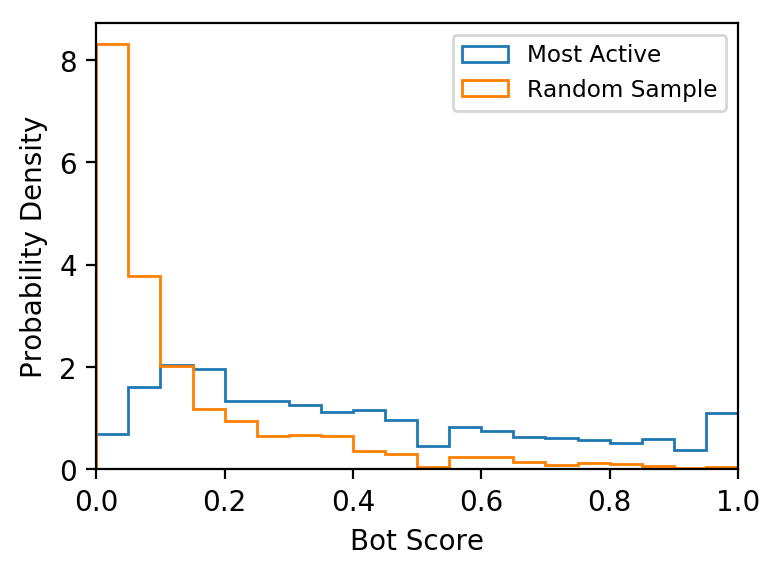

In [30]:
fn1 = join(DATA_DIR, 'S10_top1000_users.lc.csv')
fn2 = join(DATA_DIR, 'S10_rand1000_users.lc.csv')
fn3 = join(DATA_DIR, 'sub_user_bot_score.calibrated.csv')
nbins=20
normed=True

df1 = pd.read_csv(fn1)
df2 = pd.read_csv(fn2)
df3 = pd.read_csv(fn3, usecols=['user_raw_id', 'bot_score'])
df3 = df3.loc[df3.bot_score.notnull()]
s1 = df3.loc[df3.user_raw_id.isin(df1.user_raw_id.values)].bot_score
s2 = df3.loc[df3.user_raw_id.isin(df2.user_raw_id.values)].bot_score
a1 = s1.values
a2 = s2.values
mu1 = np.mean(a1)
sigma1 = np.std(a1, ddof=1)
mu2 = np.mean(a2)
sigma2 = np.std(a2, ddof=1)
logger.info('Number of Non-nan values: len(top)=%s, len(rand)=%s', len(a1),
            len(a2))
logger.info('Ratio of >0.5: r(top)=%s, r(rand)=%s',
            (a1 > 0.5).sum() / float(len(a1)),
            (a2 > 0.5).sum() / float(len(a2)))
logger.info('mu1=%s, mu2=%s', mu1, mu2)
logger.info('sigma1=%s, sigma2=%s', sigma1, sigma2)
logger.info('Welch\'s t-test: %s', ttest_ind(a1, a2, equal_var=False))
logger.info('Kolmogorov-Smirnov test: %s', ks_2samp(a1, a2))
logger.info('Mann Whitney U test: %s', mannwhitneyu(a1, a2))
fig, ax = plt.subplots(figsize=FIGSIZE)
bins = np.linspace(0, 1, nbins + 1)
if normed is False:
    w1 = np.ones_like(a1) / len(a1)
    w2 = np.ones_like(a2) / len(a2)
else:
    w1 = None
    w2 = None
ax.set_xlim([0, 1])
ax.hist(
    a1,
    bins,
    weights=w1,
    normed=normed,
    alpha=1,
    label='Most Active',
    histtype='step',
    color=C1)
ax.hist(
    a2,
    bins,
    weights=w2,
    normed=normed,
    alpha=1,
    label='Random Sample',
    histtype='step',
    color=C2)
plt.legend(loc='upper right', fontsize='small')
ax.set_xlabel('Bot Score')
if normed is True:
    ax.set_ylabel('Probability Density')
else:
    ax.set_ylabel('$proportion$')
plt.tight_layout()
plt.show()

### Figure S11

**Caption in the supplementary paper**:

Supplementary Figure 11: Temporal evolution of bot support after the first share of a viral story from a consensus low-credibility source. We consider a random sample of 20,000 accounts out of the 163,563 accounts that participate in the spread of the 1,000 most viral articles. After articles from The Onion are excluded, we are left with 42,202 tweets from 13,926 accounts. We align the times when each link first appears. We focus on a one-hour early spreading phase following each of these events, and divide it into logarithmic lag intervals. The plot shows the bot score distribution for accounts sharing the links during each of thee lag intervals.

**Input data and instructions**:

`S11_first_hour_tweets_for_top1000_articles.lc.csv`: first hour tweets for top 1000 most shared low-credibility articles

`S11_sampled_first_hour_users_for_top1000_articles.lc.csv`: 20,000 accounts sampled from `S11_first_hour_tweets_for_top1000_articles.lc.csv`

`sub_user_bot_score.calibrated.csv`: bot score for the accounts

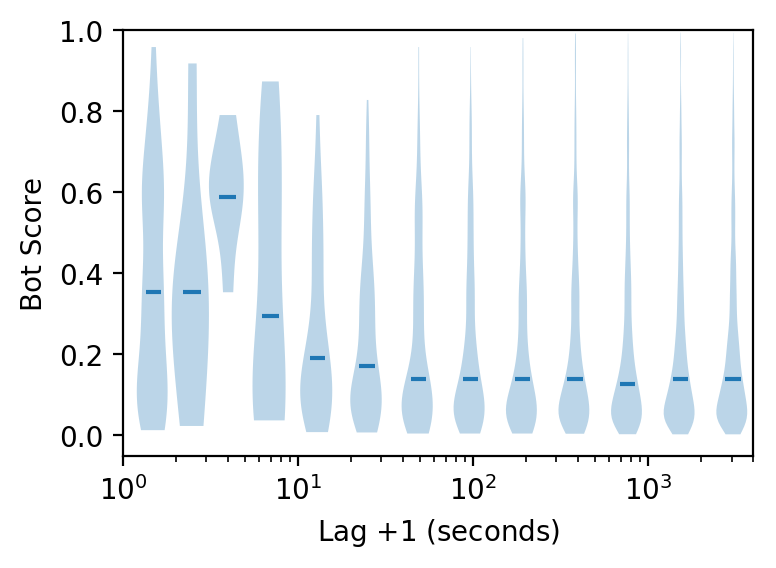

In [31]:
fn1 = join(DATA_DIR, 'S11_first_hour_tweets_for_top1000_articles.lc.csv')
fn2 = join(DATA_DIR, 'S11_sampled_first_hour_users_for_top1000_articles.lc.csv')
fn3 = join(DATA_DIR, 'sub_user_bot_score.calibrated.csv')

with_theonion = False
first = False
base = 2

df1 = pd.read_csv(fn1)
df2 = pd.read_csv(fn2)
df3 = pd.read_csv(fn3, usecols=['user_raw_id', 'bot_score'])
if with_theonion is False:
    df1 = df1.loc[df1.site_id != 129]
df3 = df3.loc[df3.bot_score.notnull()]
df3 = df3.loc[df3.user_raw_id.isin(df2.user_raw_id.values)]
df = pd.merge(df1, df3, on='user_raw_id', how='inner')
logger.info('%s tweets from %s accounts', df.tweet_id.nunique(),
            df.user_raw_id.nunique())
df.sort_values('second', inplace=True)
if first is True:
    logger.info('Keep first appeared tweets only!')
    logger.info('Before drop duplicates: %s', len(df))
    df = df.drop_duplicates(['article_id', 'user_raw_id'], keep='last')
    logger.info('After drop duplicates: %s', len(df))
X = df.second.values + 1
logger.info('Maximum seconds is: %s', X.max())
if len(df.loc[df.second == 1]) > 0:
    logger.info('bin [1,2) needed!')
    nxbins = int(np.ceil(nplog(X.max(), base=base))) + 1
    xbins = np.ones(nxbins + 1)
    xbins[1:] = 1 + base**np.arange(0, nxbins)
else:
    logger.info('bin [1,2) not needed!')
    nxbins = int(np.ceil(nplog(X.max(), base=base)))
    xbins = base**np.arange(0, nxbins + 1)
logger.info('xbins are %s', xbins)
data = []
for i in range(nxbins - 1):
    dfi = df.loc[(X >= xbins[i]) & (X < xbins[i + 1])]
    data.append(dfi.bot_score.values)
dfi = df.loc[(X >= xbins[nxbins - 1]) & (X <= xbins[nxbins])]
data.append(dfi.bot_score.values)
f, ax = plt.subplots(figsize=FIGSIZE)
positions = xbins[:-1] + np.true_divide(xbins[1:] - xbins[:-1], 2)
logger.info('positions=%s', positions)
ax.violinplot(
    data,
    positions=positions,
    vert=True,
    widths=0.6 * xbins[:-1],
    showmeans=False,
    showextrema=False,
    showmedians=True,
    points=100,
)
ax.set_xlabel('Lag $+1$ (seconds)')
ax.set_ylabel('Bot Score')
ax.set_ylim([-0.05, 1.0])
ax.set_xscale('log')
ax.set_xlim([1, 4e3])
plt.tight_layout()
plt.show()

### Figure S12

**Caption in the supplementary paper**:

Supplementary Figure 12: Average number of followers for Twitter users who are mentioned (or replied to) by a sample of 20,000 accounts that link to the 1,000 most viral articles from consensus low-credibility sources. We obtained bot scores for 4,006 unique mentioning accounts and 4,965 unique mentioned accounts, participating in 33,112 mention/reply pairs. We excluded 13,817 of these pairs using the "via @screen_name" mentioning pattern. The mentioning accounts are aggregated into three groups by bot score percentile. Error bars indicate standard errors. Inset: Distributions of follower counts for users mentioned by accounts in each percentile group.

**Input data and instructions**:

`S12_sampled_mentions.20000.csv`: mentions from these random sampled 20,000 accounts. (see S11)

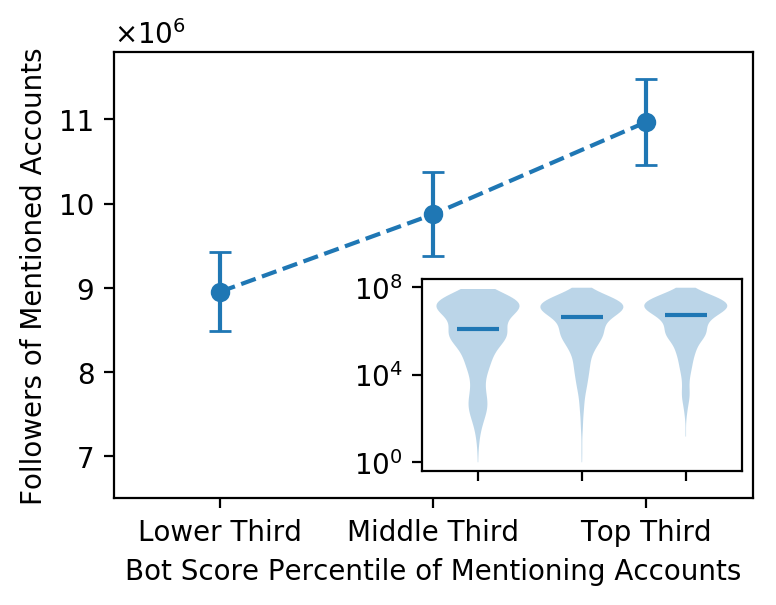

In [44]:
fn = join(DATA_DIR, 'S12_sampled_mentions.20000.csv')
discard_via = True
nbins = 3

df = pd.read_csv(fn)
if discard_via is True:
    df = df.loc[~df.is_via_word_in_tweet_text,
                ['from_raw_id', 'from_bot_score', 'to_followers_count']]
df = df.groupby('from_raw_id').mean()
df = df.sort_values('from_bot_score', ascending=True)
df = df.reset_index(drop=True)
df = assign_segregated_groups(df, nbins)
gpb = df.groupby('gn')
d_mean = gpb.to_followers_count.mean()
d_std = gpb.to_followers_count.std()
d_size = gpb.size()
x = np.array(range(3))
y1 = d_mean.values / 1e6
y1err = d_std / d_size.apply(np.sqrt) / 1e6
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.errorbar(x, y1, yerr=y1err, fmt='--o', capsize=4)
ax.set_xticks(x)
ax.set_xticklabels(['Lower Third', 'Middle Third', 'Top Third'])
ax.set_xlabel('Bot Score Percentile of Mentioning Accounts')
ax.set_ylabel('Followers of Mentioned Accounts')
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([6.5, 11.8])
ax.text(
    0,
    1.02,
    r'$\times10^6$',
    transform=ax.transAxes,
    horizontalalignment='left')
iax = plt.axes([.54, .24, .4, .32])
df.loc[:, 'to_followers_count'] = np.log10(df.to_followers_count)
data = []
for name, gp in df.groupby('gn'):
    data.append(gp['to_followers_count'].values)
iax.violinplot(
    data,
    positions=x + 0.15,
    vert=True,
    widths=0.8,
    showmeans=False,
    showextrema=False,
    showmedians=True,
    points=100,
)
iax.set_xticks(x + 0.15)
iax.set_xticklabels([])
iax.set_yticks([0, 4, 8])
iax.yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, y: r'$10^%d$' % x))
plt.tight_layout()
plt.show()

### Figure S13 & S14

Function to plot S13 and S14

In [35]:
def plot_bots_retweeter_and_tweeter(
    fn1='S13_retweeter_and_tweeter.csv',
    fn2='sub_user_bot_score.calibrated.csv',
    exclude_account=True,
    nbins=20,
    figsize=(6, 4.5)):

    fn1 = join(DATA_DIR, fn1)
    fn2 = join(DATA_DIR, fn2)
    
    df1 = pd.read_csv(fn1)
    df2 = pd.read_csv(fn2)
    df2 = df2.loc[df2.bot_score.notnull()]
    if exclude_account is True:
        # exlude @PrisonPlanet
        df1 = df1.loc[df1.tweeter_id != 18643437]
    df = pd.merge(
        df2, df1, left_on='user_raw_id', right_on='retweeter_id', how='inner')
    df.rename(columns=dict(bot_score='retweeter_score'), inplace=True)
    df = pd.merge(
        df2, df, left_on='user_raw_id', right_on='tweeter_id', how='inner')
    df.rename(columns=dict(bot_score='tweeter_score'), inplace=True)
    df = df[['retweeter_score', 'tweeter_score']].copy()
    x = df.retweeter_score.values
    y = df.tweeter_score.values
    H, xedges, yedges = np.histogram2d(
        x, y, bins=np.linspace(0.0, 1.0, nbins + 1))
    # X1, Y1, horizontal curve
    df = pd.DataFrame(H)
    X1 = xedges[:-1] + np.true_divide(xedges[1:] - xedges[:-1], 2)
    Y1 = df.sum(axis=1) / df.sum(axis=1).sum()
    # X2, Y2, vertical curve
    df2 = df.iloc[:10]
    X2 = df2.sum(axis=0) / df.sum(axis=0).sum()
    Y2 = X1
    # X3, Y3, heatmap
    X3, Y3 = np.meshgrid(xedges, yedges)

    plt.figure(figsize=figsize)
    # Display -> Figure
    # figtr = fig.transFigure.inverted()
    gs = gridspec.GridSpec(
        2,
        4,
        wspace=0.3,
        hspace=0.2,
        width_ratios=[2.5, 6, 0.2, 0.5],
        height_ratios=[0.8, 2])
    # gs[0, 1].update(hspace=0.1)
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[1, 3])
    # horizontal curve
    ax1.plot(X1, Y1)
    # verticla curve
    ax2.plot(X2, Y2)
    # heatmap
    im = ax3.pcolormesh(
        X3,
        Y3,
        H.T,
        norm=mpl.colors.LogNorm(vmin=H.min() + 1, vmax=H.max()),
        cmap='gnuplot2_r')
    # color bar
    cb = plt.colorbar(im, ax=ax4, orientation='vertical', fraction=0.9)
    cb.set_label('Retweets')
    # disable xticklabels of ax1
    ax1.set_xticklabels([])
    # disable xticklabels of ax2
    ax2.set_yticklabels([])
    # set tick on right yaxis of ax2
    ax2.yaxis.tick_right()
    # add vertical dashed line on ax1
    ax1.axvline(0.5, color='k', linestyle='--', lw=0.5)
    # add xlabel
    ax1.set_ylabel('$\Pr(x)$')
    ax1.set_ylim((0, 0.2))
    # add horizontal dashed line on ax2
    ax2.axhline(0.5, color='k', linestyle='--', lw=0.5)
    # set inverse xlim of ax2, making xaxis increasing on inverse direction
    if exclude_account is True:
        ax2.set_xlim((0.2, 0))
    else:
        ax2.set_xlim((0.4, 0))

    # add ylabel
    ax2.set_xlabel('$\Pr(y|x\leq 0.5)$')
    # fontsize=rcParams['axes.titlesize'],
    # fontweight=rcParams['axes.titleweight'])
    # set xlabel of ax3
    ax3.set_xlabel('Bot Score of Retweeter, $x$')
    # set ylabel of ax3
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position("right")
    ax3.set_ylabel('Bot Score of Tweeter, $y$')
    # disable axis
    ax4.axis('off')
    # add rectangel for ax3
    rect = mpl.patches.Rectangle(
        (0.015, 0.008),
        0.49,
        0.98,
        alpha=1,
        ec='black',
        facecolor=None,
        fill=False,
        ls='-.',
        lw=1.5)
    ax3.add_patch(rect)
    plt.show()

**Caption in the supplementary paper**:

Supplementary Figure 13: Joint distribution of the bot scores of accounts that retweeted links to articles from consensus low-credibility sources and accounts that had originally posted the links. We considered retweets by a sample of 20,000 accounts that posted the 1,000 most viral articles. We obtained bot scores for 12,792 tweeting accounts and 17,664 retweeting accounts, participating in 229,725 retweet pairs. Color represents the number of retweeted messages in each bin, on a log scale. Projections show the distributions of bot scores for retweeters (top) and for accounts retweeted by likely humans (left).

**Input data and instructions**:

`S13_retweeter_and_tweeter.csv`: retweeter and tweeter from sampled 20, 000 accounts

`sub_user_bot_score.calibrated.csv`: bot score for retweeter and tweeter

`exclude_account`: the account `@PrisonPlanet` contributes so many retweets that it overloads others. Set this flag to exclude this account.

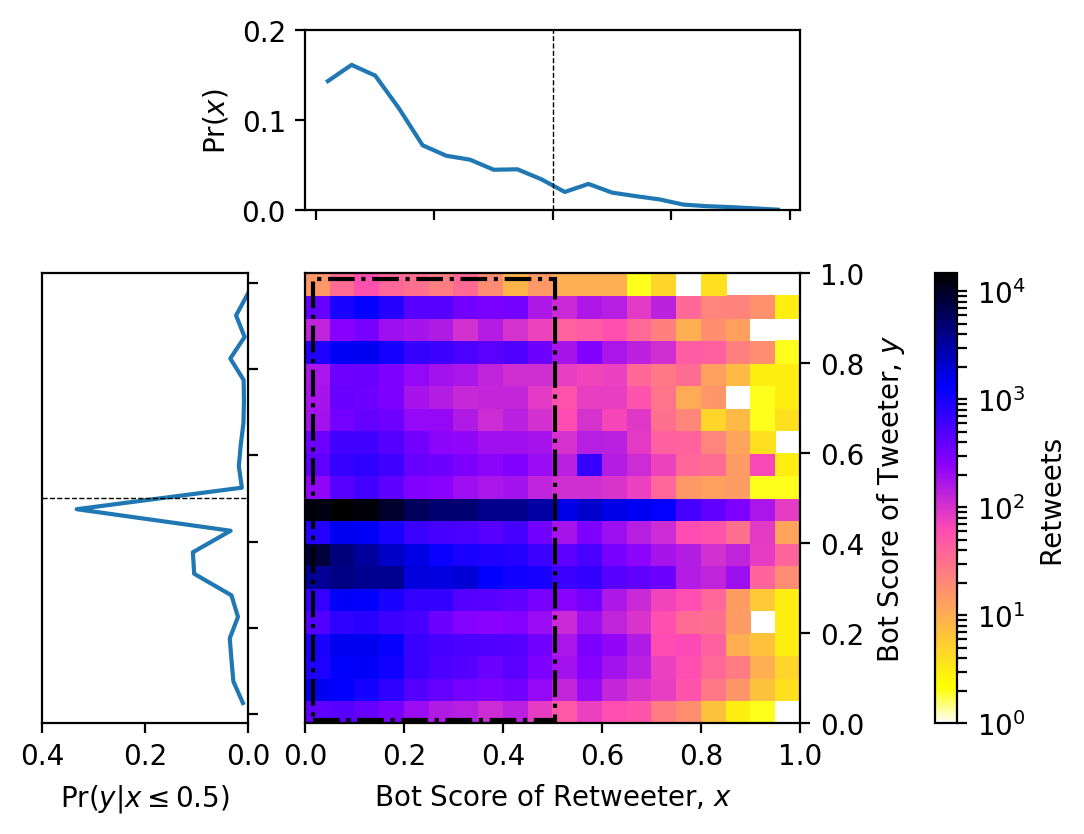

In [36]:
plot_bots_retweeter_and_tweeter(exclude_account=False)

**Caption in the supplementary paper**:

Supplementary Figure 14: Joint distribution of the bot scores of accounts that retweeted links toarticles from consensus low-credibility sources and accounts that had originally posted the links.The analysis is identical to that in Supplementary Fig. 13, except that retweets of posts by a singleaccount, @PrisonPlanet, are removed.

**Input data and instructions**:

`S13_retweeter_and_tweeter.csv`: retweeter and tweeter from sampled 20, 000 accounts

`sub_user_bot_score.calibrated.csv`: bot score for retweeter and tweeter

`exclude_account`: the account `@PrisonPlanet` contributes so many retweets that it overloads others. Set this flag to exclude this account.

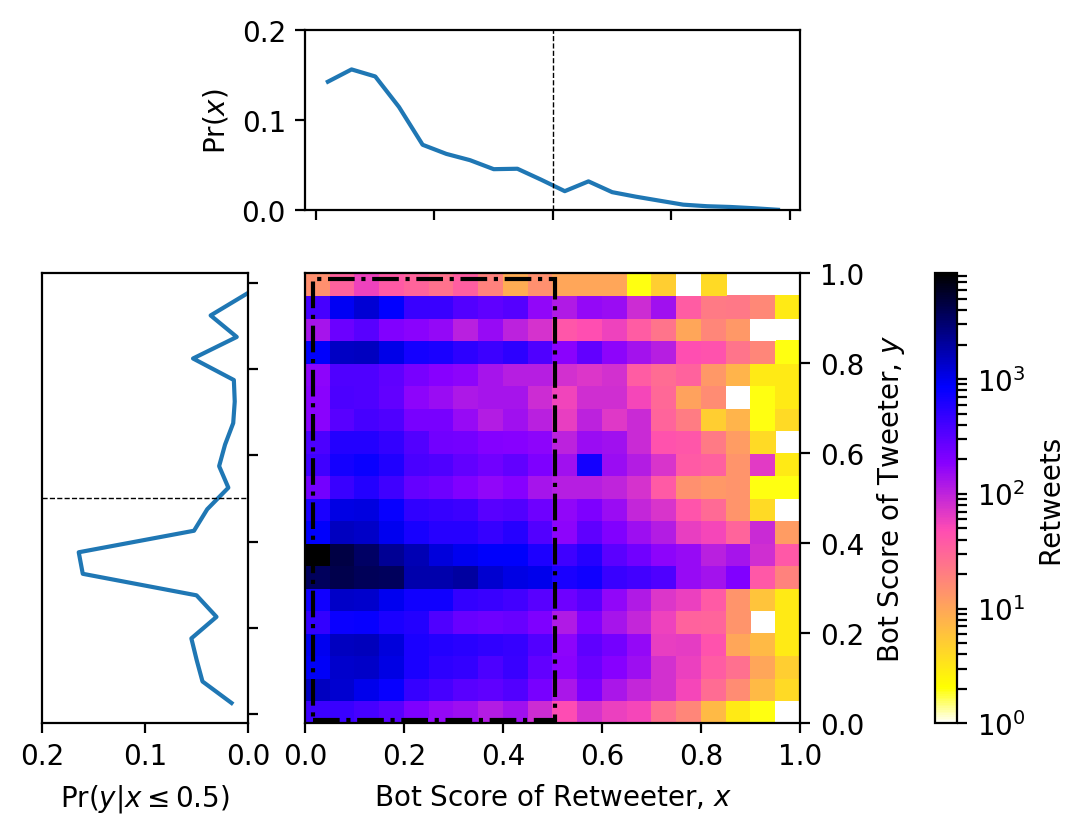

In [37]:
plot_bots_retweeter_and_tweeter(exclude_account=True)

### Figure S15a

**Caption in the supplementary paper**:

Analyses based on consensus low-credibility sources with the exclusion of Breitbart.com.

**Input data and instructions**:

The input and instruction are the same with Figure 10 except Breitbart.com is removed from the analysis.

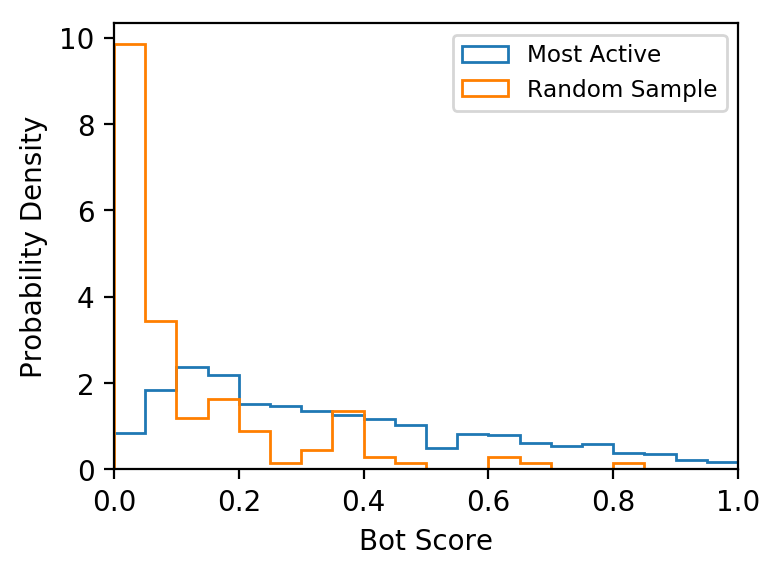

In [34]:
fn1 = join(DATA_DIR, 'S10_top1000_users.lc.csv')
fn2 = join(DATA_DIR, 'S10_rand1000_users.lc.csv')
fn3 = join(DATA_DIR, 'sub_user_bot_score.calibrated.csv')
fn4 = join(DATA_DIR, 'S11_first_hour_tweets_for_top1000_articles.lc.csv')
nbins=20
normed=True

df1 = pd.read_csv(fn1)
df2 = pd.read_csv(fn2)
df3 = pd.read_csv(fn3, usecols=['user_raw_id', 'bot_score'])
df3 = df3.loc[df3.bot_score.notnull()]
df4 = pd.read_csv(fn4, usecols=['user_raw_id', 'site_id'])
# exclude Breitbart.com
df4 = df4.loc[df4.site_id != 95]
non_breit_u = set(df4.user_raw_id.values)

df1 = df3.loc[df3.user_raw_id.isin(df1.user_raw_id.values)]
df2 = df3.loc[df3.user_raw_id.isin(df2.user_raw_id.values)]
df1 = df1.loc[df1.user_raw_id.isin(non_breit_u)]
df2 = df2.loc[df2.user_raw_id.isin(non_breit_u)]
a1 = df1.bot_score.values
a2 = df2.bot_score.values

mu1 = np.mean(a1)
sigma1 = np.std(a1, ddof=1)
mu2 = np.mean(a2)
sigma2 = np.std(a2, ddof=1)
logger.info('Number of Non-nan values: len(top)=%s, len(rand)=%s',
            len(a1), len(a2))
logger.info('Ratio of >0.5: r(top)=%s, r(rand)=%s',
            (a1 > 0.5).sum() / float(len(a1)),
            (a2 > 0.5).sum() / float(len(a2)))
logger.info('mu1=%s, mu2=%s', mu1, mu2)
logger.info('sigma1=%s, sigma2=%s', sigma1, sigma2)
logger.info('Welch\'s t-test: %s',
            ttest_ind(a1, a2, equal_var=False))
logger.info('Kolmogorov-Smirnov test: %s', ks_2samp(a1, a2))
logger.info('Mann Whitney U test: %s',
            mannwhitneyu(a1, a2))
fig, ax = plt.subplots(figsize=FIGSIZE)
bins = np.linspace(0, 1, nbins + 1)
if normed is False:
    w1 = np.ones_like(a1) / len(a1)
    w2 = np.ones_like(a2) / len(a2)
else:
    w1 = None
    w2 = None
ax.set_xlim([0, 1])
ax.hist(
    a1,
    bins,
    weights=w1,
    normed=normed,
    alpha=1,
    label='Most Active',
    histtype='step',
    color=C1)
ax.hist(
    a2,
    bins,
    weights=w2,
    normed=normed,
    alpha=1,
    label='Random Sample',
    histtype='step',
    color=C2)
plt.legend(loc='upper right', fontsize='small')
ax.set_xlabel('Bot Score')
if normed is True:
    ax.set_ylabel('Probability Density')
else:
    ax.set_ylabel('$proportion$')
plt.tight_layout()
plt.show()

### Figure S15b

**Caption in the supplementary paper**:

Analyses based on consensus low-credibility sources with the exclusion of Breitbart.com.

**Input data and instructions**:

The input and instruction are the same with Figure 12 except Breitbart.com is removed from the analysis.

### Figure S15c

**Caption in the supplementary paper**:

Analyses based on consensus low-credibility sources with the exclusion of Breitbart.com.

**Input data and instructions**:

The input and instruction are the same with Figure 11 except Breitbart.com is removed from the analysis.

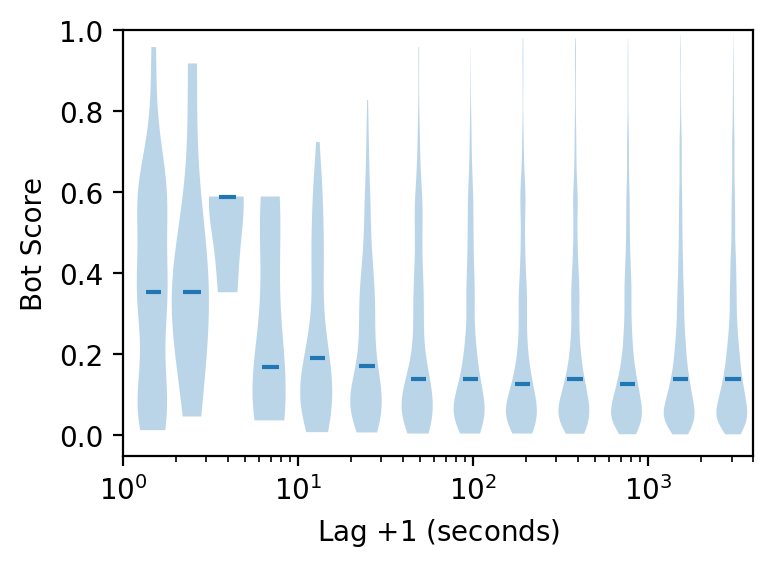

In [27]:
fn1 = join(DATA_DIR, 'S11_first_hour_tweets_for_top1000_articles.lc.csv')
fn2 = join(DATA_DIR, 'S11_sampled_first_hour_users_for_top1000_articles.lc.csv')
fn3 = join(DATA_DIR, 'sub_user_bot_score.calibrated.csv')

with_theonion = False
with_breit = False
first = False
base = 2

df1 = pd.read_csv(fn1)
df2 = pd.read_csv(fn2)
df3 = pd.read_csv(fn3, usecols=['user_raw_id', 'bot_score'])
if with_theonion is False:
    df1 = df1.loc[df1.site_id != 129]
if with_breit is False:
    df1 = df1.loc[df1.site_id != 95]
df3 = df3.loc[df3.bot_score.notnull()]
df3 = df3.loc[df3.user_raw_id.isin(df2.user_raw_id.values)]
df = pd.merge(df1, df3, on='user_raw_id', how='inner')
logger.info('%s tweets from %s accounts', df.tweet_id.nunique(),
            df.user_raw_id.nunique())
df.sort_values('second', inplace=True)
if first is True:
    logger.info('Keep first appeared tweets only!')
    logger.info('Before drop duplicates: %s', len(df))
    df = df.drop_duplicates(['article_id', 'user_raw_id'], keep='last')
    logger.info('After drop duplicates: %s', len(df))
X = df.second.values + 1
logger.info('Maximum seconds is: %s', X.max())
if len(df.loc[df.second == 1]) > 0:
    logger.info('bin [1,2) needed!')
    nxbins = int(np.ceil(nplog(X.max(), base=base))) + 1
    xbins = np.ones(nxbins + 1)
    xbins[1:] = 1 + base**np.arange(0, nxbins)
else:
    logger.info('bin [1,2) not needed!')
    nxbins = int(np.ceil(nplog(X.max(), base=base)))
    xbins = base**np.arange(0, nxbins + 1)
logger.info('xbins are %s', xbins)
data = []
for i in range(nxbins - 1):
    dfi = df.loc[(X >= xbins[i]) & (X < xbins[i + 1])]
    data.append(dfi.bot_score.values)
dfi = df.loc[(X >= xbins[nxbins - 1]) & (X <= xbins[nxbins])]
data.append(dfi.bot_score.values)
f, ax = plt.subplots(figsize=FIGSIZE)
positions = xbins[:-1] + np.true_divide(xbins[1:] - xbins[:-1], 2)
logger.info('positions=%s', positions)
ax.violinplot(
    data,
    positions=positions,
    vert=True,
    widths=0.6 * xbins[:-1],
    showmeans=False,
    showextrema=False,
    showmedians=True,
    points=100,
)
ax.set_xlabel('Lag $+1$ (seconds)')
ax.set_ylabel('Bot Score')
ax.set_ylim([-0.05, 1.0])
ax.set_xscale('log')
ax.set_xlim([1, 4e3])
plt.tight_layout()
plt.show()

### Figure S15d

**Caption in the supplementary paper**:

Analyses based on consensus low-credibility sources with the exclusion of Breitbart.com.

**Input data and instructions**:

The input and instruction are the same with Figure 13 except Breitbart.com is removed from the analysis.

### Figure S16

**Caption in the supplementary paper**:

Supplementary Figure 16 : Distributions of bot scores versus account activity. For this analysis we randomly selected 48,517 distinct Twitter accounts evaluated by Botometer. Of these, 11,190 were available for crawling their profiles and measuring their activity (number of tweets). Bins correspond to deciles in the activity rate. We show the average and 95% confidence interval for the bot score distribution of the accounts in each activity bin. There is no correlation between activity and bot score (Pearson’s rho=−0.007).

**Input data and instructions**:

`activity_botscore.csv`: 11,190 sampled Twitter accounts' activity information and botscores. This file is generated directly from Twitter's API and can be found in the raw data repository.

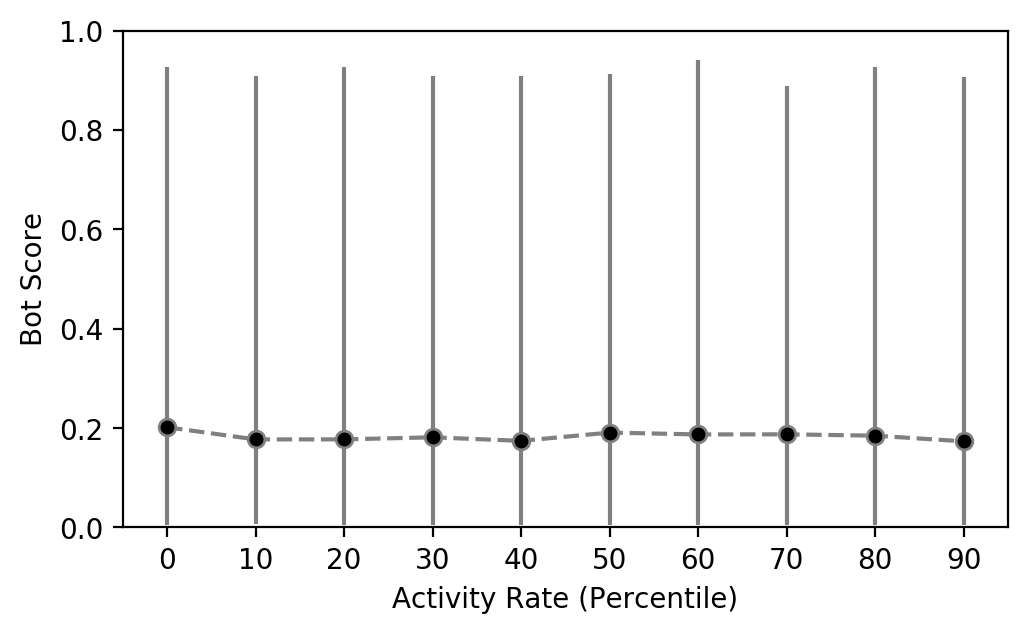

In [42]:
fn = join(RAW_DATA_DIR, "activity_botscore.csv")
df = pd.read_csv(fn)

figsize = (5, 3)
q = np.linspace(0, 100, 10, endpoint=False)
p = np.percentile(df['activity'], q)
d = np.digitize(df['activity'], p)

dfg = df.groupby(d).agg({'bot_score_english':{
    'mean': 'mean', 
    'yql': lambda k: np.percentile(k, 2.75),
    'yqu': lambda k: np.percentile(k, 97.5)
}})
dfg = dfg['bot_score_english']
yerr = np.vstack([dfg['mean'] - dfg['yql'], dfg['yqu'] - dfg['mean']])
dfg = dfg.set_index(q)
fig, ax = plt.subplots(figsize=figsize)
ax.errorbar(x=dfg.index, 
         y=dfg['mean'], 
         yerr=yerr,
         marker='o', 
         ls='dashed', 
         color='gray', 
         markerfacecolor='k')
ax.set_xlim(-5, 95)
ax.set_ylim(0, 1.0)
ax.set_xlabel('Activity Rate (Percentile)')
ax.set_ylabel('Bot Score')
ax.set_xticks(q)
plt.tight_layout(pad=0.1)
plt.show()